# Meta Fusion Model 

Loading the Required Imports

In [53]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve,auc,r2_score
from sklearn.model_selection import train_test_split
from lifelines.plotting import qq_plot
from sklearn.calibration import calibration_curve
import sklearn.linear_model as lm
import seaborn as sg
import warnings
import pickle
import os
from lifelines.calibration import survival_probability_calibration
from pickle import loads, dumps


Defining all the required functions

In [54]:
def get_ancestry():
    #grep 'final maxval' iADMIX*bam.input.ancestry > /pgen-hardcall-nothreshold/tempus/ancestry
    anc = pd.read_csv("/pgen-hardcall/admixed/ancestry/ancestry",header=None,sep=" ",index_col=0)
    anc.index = [int(i.split(".")[2]) for i in anc.index]
    anc = anc.iloc[:,3:8]
    columns = []
    for c in anc.columns:
        columns.append(anc[c].iloc[0].split(":")[0])
        anc[c] = anc[c].apply(lambda x:  str(x).split(':')[1])
    anc.columns = columns
    return anc

def get_prs():
    base_path = "/app/pipeline/pgscatalog/ukbbank_scores/cad_nuovo_panel/%s/plink2.sscore"
    ukbbscore = pd.DataFrame(pd.concat([pd.read_csv(base_path % (i),
                                   sep="\t", index_col='IID') for i in range(1,23)],axis=1))['SCORE1_SUM'].sum(axis=1)
    ukbbscore = pd.DataFrame(ukbbscore)
    ukbbscore.columns = ['prs']
    #ukbbscore['IID'] = ukbbscore.index
    ukbbscore = ukbbscore.reset_index()
    prs_cad = ukbbscore[['IID','prs']]
    prs_cad = prs_cad.set_index('IID')
    return prs_cad



def plot_calibration_km(predictions,original_dataset,cens=3286.0,bins=10,col="time",truncation=False):
    """
    Only suitable for 75 risk
    """
    bound = predictions[0].columns[predictions[0].columns >= 75][0]
    print("****BOUND****:",bound)
    j = pd.DataFrame(predictions[0][bound])
    j.columns = ['predict']
    Xtest = original_dataset.join(j,how='right')
    binned = stats.rankdata(Xtest['predict'],'average')/Xtest.shape[0]*bins
    Xtest['binned'] = [round(i) for i in binned]
    Xtest.sort_values(by='binned',inplace=True)

    bins = []
    prevalence = []
    for i in Xtest['binned'].unique():
        individual_in_bin = Xtest[Xtest['binned'] == i]
        kmf = KaplanMeierFitter()
        
        if truncation:
            kmf.fit(individual_in_bin['age_disease'],
                    individual_in_bin['pheno'],
                    entry=individual_in_bin[truncation])
        else:
            kmf.fit(individual_in_bin['age_disease'],
                    individual_in_bin['pheno'])
        #prevalent 
        prevalence.append((1-kmf.predict(bound))*100)
        bins.append(individual_in_bin['predict'].mean()*100)
        
    plt.figure(figsize=(2, 2), dpi=300)
    plt.plot([i for i in range(0,90)],[i for i in range(0,90)])
    plt.plot(bins,prevalence,'.')
    plt.xlim(0,np.max(bins)+1)
    plt.ylim(0,np.max(bins)+1)
    plt.xlabel('Predicted Risk')
    plt.ylabel('Observed Risk')  
    return (prevalence,bins)  


def plot_calibration_km_rcox(predictions,original_dataset,baseline_age,title, cens=3286.0,bins=10,col="time",truncation=False):
    """
    Only suitable for 75 risk
    """
    bound = baseline_age
    j = pd.DataFrame(predictions)
    j.columns = ['predict']
    Xtest = original_dataset.join(j,how='right')
    binned = stats.rankdata(Xtest['predict'],'average')/Xtest.shape[0]*bins
    Xtest['binned'] = [round(i) for i in binned]
    Xtest.sort_values(by='binned',inplace=True)

    bins = []
    prevalence = []
    for i in Xtest['binned'].unique():
        individual_in_bin = Xtest[Xtest['binned'] == i]
        kmf = KaplanMeierFitter()
        
        if truncation:
            kmf.fit(individual_in_bin['age_disease'],
                    individual_in_bin['affected'],
                    entry=individual_in_bin[truncation])
        else:
            kmf.fit(individual_in_bin['age_disease'],
                    individual_in_bin['affected'])
        #prevalent 
        prevalence.append((1-kmf.predict(bound))*100)
        bins.append(individual_in_bin['predict'].mean()*100)
        
    plt.figure(figsize=(2, 2), dpi=300)
    plt.plot([i for i in range(0,90)],[i for i in range(0,90)])
    plt.plot(bins,prevalence,'.')
    plt.xlim(0,np.max(bins)+1)
    plt.ylim(0,np.max(bins)+1)
    plt.xlabel('Predicted Risk')
    plt.ylabel('Observed Risk')
    plt.title(title)
    return (prevalence,bins)  






def plot_calibration(predictions,original_dataset, risk=''):
    """
    Only suitable for 75 risk
    """
    predictions = predictions.join(original_dataset)
    predictions.loc[:,'binned'] = np.round(stats.rankdata(predictions[risk],'average')/predictions.shape[0]*10, 0)
    
    
    x = []
    y= []
    for i in np.sort(predictions['binned'].unique()):
        individual_in_bin = predictions[predictions['binned'] == i]
        average_actual = individual_in_bin['affected'].mean()
        average_predicted = individual_in_bin[risk].mean()
        x.append(average_predicted)
        y.append(average_actual)
          
 
    return x,y

'''
    bins = []
    prevalence = []
    for i in Xtest['binned'].unique():
        individual_in_bin = Xtest[Xtest['binned'] == i]
        kmf = KaplanMeierFitter()
        
        if truncation:
            kmf.fit(individual_in_bin['age_disease'],
                    individual_in_bin['pheno'],
                    entry=individual_in_bin[truncation])
        else:
            kmf.fit(individual_in_bin['age_disease'],
                    individual_in_bin['pheno'])
        #prevalent 
        prevalence.append((1-kmf.predict(bound))*100)
        bins.append(individual_in_bin['predict'].mean()*100)
        
    plt.figure(figsize=(2, 2), dpi=300)
    plt.plot([i for i in range(0,90)],[i for i in range(0,90)])
    plt.plot(bins,prevalence,'.')
    plt.xlim(0,np.max(bins)+1)
    plt.ylim(0,np.max(bins)+1)
    plt.xlabel('Predicted Risk')
    plt.ylabel('Observed Risk')  
    return (prevalence,bins)  
'''






def plot_calibration_km_mix(predictions,original_dataset,cens=3286.0,bins=10,col="time",truncation=False):
    """
    Only suitable for 75 risk
    """
    j = pd.DataFrame(predictions)
    j.columns = ['predict']
    Xtest = original_dataset.join(j,how='left')
    binned = stats.rankdata(Xtest['predict'],'average')/Xtest.shape[0]*bins
    print("BINNED", binned)
    Xtest['binned'] = [round(i) for i in binned]
    Xtest.sort_values(by='binned',inplace=True)

    bins = []
    prevalence = []
    for i in Xtest['binned'].unique():
        individual_in_bin = Xtest[Xtest['binned'] == i]
        kmf = KaplanMeierFitter()
        if truncation:
            kmf.fit(individual_in_bin['age_disease'],
                    individual_in_bin['pheno'],
                    entry=individual_in_bin[truncation])
        else:
            kmf.fit(individual_in_bin['age_disease'],
                    individual_in_bin['pheno'])
        bound = 75
        prevalence.append((1-kmf.predict(bound))*100)
        bins.append(individual_in_bin['predict'].mean())
        
    plt.figure(figsize=(3, 3), dpi=300)
    plt.plot([i for i in range(0,90)],[i for i in range(0,90)])
    plt.plot(bins,prevalence,'.')
    plt.xlim(0,np.max(bins)+1)
    plt.ylim(0,np.max(bins)+1)
    plt.xlabel('Predicted Risk')
    plt.ylabel('Observed Risk')  
    return (prevalence,bins)  


def generate_prediction(dataset,
                        col="age_disease",
                        iteration=1,
                        test_size=0.2,
                        split=True,
                        debug=True,
                        truncation=False):
    result = []
  
    i=0
    while i < iteration:
        if debug:
            print("Iteration: %s" % str(i+1))
        #split
        if split == True:
            Xtrain, Xtest, xtrain, xtest = train_test_split(dataset,
                                                    dataset['pheno'], 
                                                    test_size=test_size) 
        else:
            Xtrain, Xtest, xtrain, xtest = dataset,dataset,dataset['pheno'],dataset['pheno']
        
        
        
        Xtrain = Xtrain.dropna()
        print(Xtrain.shape)
        print(Xtrain.columns)
        
        #Xtrain.drop(['gender','EUR'], axis = 1, inplace = True)
        #Xtrain.drop(['EAS'], axis = 1, inplace = True)
        print(Xtrain.columns)
        
        #if not fit redo                                            
        model = CoxPHFitter()
        if(truncation != False):
            model.fit_right_censoring(Xtrain, col, 'pheno',entry_col=truncation) #age
        else:
            model.fit_right_censoring(Xtrain, col, 'pheno', entry_col=truncation)
        #predict
        pred = (1-model.predict_survival_function(Xtest)).T
        
        result.append(pred)
       
        i = i+1
    return result,model

def standardize(ds,variables):
    for i in variables:
        ds[i] = (ds[i] - ds[i].mean()) / ds[i].std()
    return ds

def prepare_dataset(d):
    d = d[d['time'] > 0]
    d['pheno'] = d['affected']
    #Add sex as Covariate
    #d = d[['pheno','age_enroll','age_disease','pca1_x','pca2_x','pca3_x','pca4_x','gender','geno_array_x','prs','EUR','AFR','EAS','SAS']]
    
    #d = d[['pheno','age_enroll','age_disease','pca1_x','pca2_x','pca3_x','pca4_x','gender','geno_array_x','prs']]
    
    d = d[['pheno','age_enroll','age_disease','pca1_x','pca2_x','pca3_x','pca4_x','geno_array_x','prs']]
    
    
    d = d.dropna()
    return d

def modeling(d,pca=True,truncation=True):
    d = prepare_dataset(d)
    print(d.shape)
    if pca == False:
        d = d.drop(columns=['pca1_x','pca2_x','pca3_x','pca4_x']) #use the PCA and remove the anc columns
    predictions_75,model_75 = generate_prediction(d,
                                           iteration=1,
                                           col='age_disease',
                                           split=False,
                                           truncation=truncation)
    
    _ = plot_calibration_km(predictions_75,d,
                            col="age_disease",bins=8, truncation=truncation)
    return model_75,predictions_75



def get_ukbbscore_classic(basepath,trait,variants=False,eid=[]):
    if trait == 'alz_with_apoeid':
        trait = 'alz_with_apoe'
    print(basepath % (trait,22))
    col='SCORE1_SUM'
    if variants:
        col='NMISS_ALLELE_CT'
    res = pd.DataFrame(pd.concat([pd.read_csv(basepath % (trait,i),
                               sep="\t", index_col='IID') 
                            for i in range(1,23)
                        if os.path.isfile(basepath % (trait,i))],axis=1))[col].sum(axis=1)
    return res



def apply_metafuse(df,metafuse_params,baseline):
    
    #Average Risk
    average_risk = (df.mean() * metafuse_params).sum()
    
    #Features Multiplied with PCE params
    feature_x_params = df * metafuse_params

    #Sum the features
    feature_x_params['sum_features'] = feature_x_params[list(feature_x_params.columns)].sum(axis=1)

    #Calculating PCE risk with survival hazard formula
    metafuse_risk = pd.DataFrame(1 - pow(baseline, np.exp(feature_x_params['sum_features'] - average_risk)))
    metafuse_risk = metafuse_risk.rename(columns={"sum_features":"mfuse_risk"})
    
    return metafuse_risk


def apply_metafuse_weighted(df,baseline):
    
    #Average Risk
    average_risk = (df.mean() * df[[]]).sum()
    
    #Features Multiplied with PCE params
    feature_x_params = df * metafuse_params

    #Sum the features
    feature_x_params['sum_features'] = feature_x_params[list(feature_x_params.columns)].sum(axis=1)

    #Calculating PCE risk with survival hazard formula
    metafuse_risk = pd.DataFrame(1 - pow(baseline, np.exp(feature_x_params['sum_features'] - average_risk)))
    metafuse_risk = metafuse_risk.rename(columns={"sum_features":"mfuse_risk"})
    return metafuse_risk



In [55]:
#Get the PRS for T2D trait 
prs = get_ukbbscore_classic("/app/pipeline/pgscatalog/ukbbank_scores/%s/%s/plink2.sscore","our_t2d")

/app/pipeline/pgscatalog/ukbbank_scores/our_t2d/22/plink2.sscore


In [118]:
#Loading the Dataset for T2D
dataset = pd.read_csv("/home/paolo/t2d_dataset_for_75_risk_all")
#Float to Int
dataset = dataset.astype({"eid": int})
dataset = dataset.set_index("eid")

#Get the Gender Data
gender = pd.read_csv("/home/paolo/gender_data",index_col="eid")
gender = gender['gender']

dataset.shape

(488306, 14)

Ancestry Data : This has sample id and its ancestry (from UK BioBank )
Each Number signifies ancestry: info on https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=1001

In [119]:
#Getting the ancestry information data
anc_data = pd.read_csv("/home/paolo/ancestry_data", index_col="eid" )

#Renaming the column names
anc_data.columns = ['unnamed','anc_info']

We now join these two dataset, to get one df with all the sample information along with its ancestry.

Now we know which sample belongs to which ancestry.

In [155]:
mapped_data = dataset.join(anc_data)
mapped_data.anc_info.value_counts()
mapped_data.shape

(488306, 16)

In [156]:
#Mapping the data

#Filter Data and Map
mapped_data['new_value'] = mapped_data['anc_info'].astype(str).str[0]
mapped_data.loc[mapped_data['new_value'] == '1', 'EUR'] = 1  # 460173 rows
mapped_data.loc[mapped_data['new_value'] == '3', 'SAS'] = 1  # 9474 rows
mapped_data.loc[mapped_data['new_value'] == '4', 'AFR'] = 1  # 7647 rows
mapped_data.loc[mapped_data['new_value'] == '5', 'EAS'] = 1  # 1504 rows


#Deleting all the rows with value as 2 and 6
#filtered_mapped_data = mapped_data[mapped_data.new_value != '2']
#filtered_mapped_data = mapped_data[mapped_data.new_value != '6']
#filtered_mapped_data = mapped_data[mapped_data.new_value != ' ']
#filtered_mapped_data = mapped_data[mapped_data.new_value != '-']

mapped_data.drop(mapped_data.loc[mapped_data['new_value']=='2'].index, inplace=True)
mapped_data.drop(mapped_data.loc[mapped_data['new_value']=='6'].index, inplace=True)
mapped_data.drop(mapped_data.loc[mapped_data['new_value']=='-'].index, inplace=True)
mapped_data.drop(mapped_data.loc[mapped_data['new_value']==' '].index, inplace=True)
mapped_data.drop(mapped_data.loc[mapped_data['new_value']=='n'].index, inplace=True)

filtered_mapped_data = mapped_data.copy()

In [157]:
#Replacing all the nan with zero
filtered_mapped_data['EUR'] = filtered_mapped_data['EUR'].replace(np.nan, 0)
filtered_mapped_data['SAS'] = filtered_mapped_data['SAS'].replace(np.nan, 0)
filtered_mapped_data['AFR'] = filtered_mapped_data['AFR'].replace(np.nan, 0)
filtered_mapped_data['EAS'] = filtered_mapped_data['EAS'].replace(np.nan, 0)


#Changing the datatype of the columns
filtered_mapped_data = filtered_mapped_data.astype({"EUR": int, "SAS": int, "AFR" : int, "EAS": int })


#Dropping not required columns
filtered_mapped_data.drop(['unnamed', 'anc_info', 'new_value','is_incident','pheno'], axis = 1, inplace = True)


#Renaming the columns to be handled in the model
filtered_mapped_data.rename(columns = {'affected':'affected', 'geno_array':'geno_array_x', 'pca1':'pca1_x', 'pca2':'pca2_x', 'pca3':'pca3_x', 'pca4':'pca4_x'}, inplace = True) 


#Joining the Gneder Data
filtered_mapped_data = filtered_mapped_data.join(gender)


#Join the PRS
filtered_mapped_data = filtered_mapped_data.join(pd.DataFrame(prs))
#Rename the column to prs
filtered_mapped_data['prs'] = filtered_mapped_data[0]


filtered_mapped_data.head()

,earliest_date,first_visit_date,time,age_enroll,age_disease,pca1_x,pca2_x,pca3_x,pca4_x,geno_array_x,affected,cause,EUR,SAS,AFR,EAS,gender,0,prs
eid,,,,,,,,,,,,,,,,,,,
2232224,2013-02-07 00:00:00,2009-05-22,1357.00,68,71.715772,-11.0693,2.58861,-1.251720,1.943600,50.0,1,icd10_E119,1,0,0,0,1.0,-0.300537,-0.300537
4755038,2015-08-12 00:00:00,2008-08-21,2547.00,65,71.974261,-10.0250,5.29794,-1.059170,1.736880,63.0,1,icd10_E119,1,0,0,0,1.0,0.018109,0.018109
2828139,1999-08-29 00:00:00,2009-04-07,-3509.00,62,52.391566,-13.1702,3.83115,2.286970,0.435217,-7.0,1,icd10_E119,1,0,0,0,0.0,0.074085,0.074085
1441997,2008-01-11 23:31:12,2009-08-29,-595.02,64,62.370701,-12.7898,5.32287,-1.464380,3.413580,90.0,1,"icd10_E119,self_reported_1223",1,0,0,0,0.0,-0.576594,-0.576594
1837739,2016-09-03 00:00:00,2009-10-26,2504.00,59,65.856517,-13.0252,2.25094,-0.830467,0.348749,85.0,1,icd10_E119,1,0,0,0,1.0,-0.050166,-0.050166


In [152]:
filtered_mapped_data.affected.value_counts()

0    453074
1     25724
Name: affected, dtype: int64

In [162]:
filtered_mapped_data.shape

(478798, 19)

In [163]:
#Removing Prevalent cases
filtered_mapped_data = filtered_mapped_data[filtered_mapped_data['time']>0].copy()

#Removing unused columns
filtered_mapped_data.drop(columns=['earliest_date','first_visit_date','cause',0], inplace=True)

#Removing NA rows
filtered_mapped_data = filtered_mapped_data.dropna()

filtered_mapped_data.shape

(469101, 15)

In [164]:
filtered_mapped_data.gender.value_counts()

0.0    255830
1.0    213271
Name: gender, dtype: int64

In [145]:
filtered_mapped_data.EUR.value_counts()

1    450535
0     18566
Name: EUR, dtype: int64

In [174]:
#Splitting data into different Ancestries 
eur_data = filtered_mapped_data[filtered_mapped_data['EUR']==1]
#eur_data = filtered_mapped_data[filtered_mapped_data['EUR']==1].sample(40000, random_state=1)
sas_data = filtered_mapped_data[filtered_mapped_data['SAS']==1]
afr_data = filtered_mapped_data[filtered_mapped_data['AFR']==1]
eas_data = filtered_mapped_data[filtered_mapped_data['EAS']==1]

In [188]:
def get_male_female_split(df, anc):
    
    data_male = df[df['gender']==1]
    data_female = df[df['gender']==0]
    
    
    if anc == 'eur':
        data_male = df[df['gender']==1].sample(20000, random_state=1)
        data_female = df[df['gender']==0].sample(20000, random_state=1)
    
    #Standardize individual ancestry data
    std_data_male = standardize(data_male,['prs','geno_array_x','pca1_x','pca2_x','pca3_x','pca4_x'])
    std_data_female = standardize(data_female,['prs','geno_array_x','pca1_x','pca2_x','pca3_x','pca4_x'])
    
    std_data_male.to_csv(anc+'_data_male.csv')
    std_data_female.to_csv(anc+'_data_female.csv')
    
    return std_data_male, std_data_female
    

In [177]:
#Get the Split and Standardized data for male and female for each ancestry
eur_data_male, eur_data_female = get_male_female_split(eur_data, 'eur')
sas_data_male, sas_data_female = get_male_female_split(sas_data, 'sas')
afr_data_male, afr_data_female = get_male_female_split(afr_data, 'afr')
eas_data_male, eas_data_female = get_male_female_split(eas_data, 'eas')

In [185]:
#Get FULL EUR Male and Female Data for Cox Model
#Already Saved
#eur_data_male_full, eur_data_female_full = get_male_female_split(eur_data, 'eur')
#Modify fucntion manually
eur_data_male_full
eur_data_female_full

In [ ]:
#Full RCOX Model EUR Male Beta = rcox_beta_eur_male_full.csv
#Full RCOX Model EUR FeMale Beta = rcox_beta_eur_female_full.csv

#Baseline Haz male = 0.1563216
#Baseline Surv male= 1 - 0.1563216
#Baseline_age male= 75.00


#Baseline Haz female = 0.08555524
#Baseline Surv female= 1 - 0.08555524
#Baseline_age female= 75.00

# Applying COX model from R

In [256]:
def get_rcox_beta(anc):
    beta = pd.read_csv('rcox_beta_'+anc+'.csv', index_col=0)
    beta_series = beta.squeeze()
    return beta_series


def apply_cox_r(df, rcox_params, baseline):
    
    #Average Risk
    average_risk = (df.mean() * rcox_params).sum()
    
    #Features Multiplied with PCE params
    feature_x_params = df * rcox_params

    #Sum the features
    feature_x_params['sum_features'] = feature_x_params[list(feature_x_params.columns)].sum(axis=1)

    #Calculating PCE risk with survival hazard formula
    rcox_risk = pd.DataFrame(1 - pow(baseline, np.exp(feature_x_params['sum_features'] - average_risk)))
    rcox_risk = rcox_risk.rename(columns={"sum_features":"rcox_risk"})
    
    return rcox_risk



def plot_calibration_km_rcox123(predictions,original_dataset,baseline_age,title, cens=3286.0,bins=10,col="time",truncation=False):
    """
    Only suitable for 75 risk
    """
    bound = baseline_age
    j = pd.DataFrame(predictions)
    j.columns = ['predict']
    Xtest = original_dataset.join(j,how='right')
    binned = stats.rankdata(Xtest['predict'],'average')/Xtest.shape[0]*bins
    Xtest['binned'] = [round(i) for i in binned]
    Xtest.sort_values(by='binned',inplace=True)

    bins = []
    prevalence = []
    for i in Xtest['binned'].unique():
        individual_in_bin = Xtest[Xtest['binned'] == i]
        kmf = KaplanMeierFitter()
        
        if truncation:
            kmf.fit(individual_in_bin['age_disease'],
                    individual_in_bin['affected'],
                    entry=individual_in_bin[truncation])
        else:
            kmf.fit(individual_in_bin['age_disease'],
                    individual_in_bin['affected'])
        #prevalent 
        prevalence.append((1-kmf.predict(bound))*100)
        bins.append(individual_in_bin['predict'].mean()*100)
        
    plt.figure(figsize=(3.5, 3.5), dpi=300)
    plt.plot([i for i in range(0,100)],[i for i in range(0,100)])
    plt.plot(bins,prevalence,'.')
    plt.xlim(0,np.max(bins)+1)
    plt.ylim(0,np.max(bins)+1)
    plt.xlabel('Predicted Risk', fontsize=7)
    plt.ylabel('Observed Risk', fontsize=7)
    plt.title(title, fontsize=7)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.savefig(title+".png")
    return (prevalence,bins)



def apply_rcox_and_plot(anc_gender, baseline, baseline_age, fulldata, title):
    
    beta = get_rcox_beta(anc_gender)
    
    print(beta)
    
    rcox_risk = apply_cox_r(fulldata, beta, baseline)
    
    fulldata_with_risk = rcox_risk.join(fulldata)
    
    plot_calibration_km_rcox123(fulldata_with_risk.rcox_risk, fulldata_with_risk, baseline_age, title, cens=3286.0, bins=10, col="age_disease", truncation=False)
    


In [ ]:
#Get FULL EUR Male and Female Data for Cox Model
#Already Saved
#eur_data_male_full, eur_data_female_full = get_male_female_split(eur_data, 'eur')

#Full RCOX Model EUR Male Beta = rcox_beta_eur_male_full.csv
#Full RCOX Model EUR FeMale Beta = rcox_beta_eur_female_full.csv

#Baseline Haz male = 0.1563216
#Baseline Surv male= 1 - 0.1563216
#Baseline_age male= 75.00


#Baseline Haz female = 0.08555524
#Baseline Surv female= 1 - 0.08555524
#Baseline_age female= 75.00

In [ ]:
0.918
0.855

In [ ]:
1-baseline_male_eur_full

In [ ]:
1-baseline_female_eur_full

In [247]:
eur_data_female_full.shape

(246193, 15)

In [243]:
1-0.1563216

0.8436783999999999

# Full Data Cox Model

geno_array_x   -0.055064
pca1_x         -0.006560
pca2_x         -0.009242
pca3_x          0.043471
pca4_x          0.077489
prs             0.481815
Name: x, dtype: float64
geno_array_x   -0.075320
pca1_x         -0.004010
pca2_x          0.005910
pca3_x          0.068107
pca4_x          0.096324
prs             0.493572
Name: x, dtype: float64


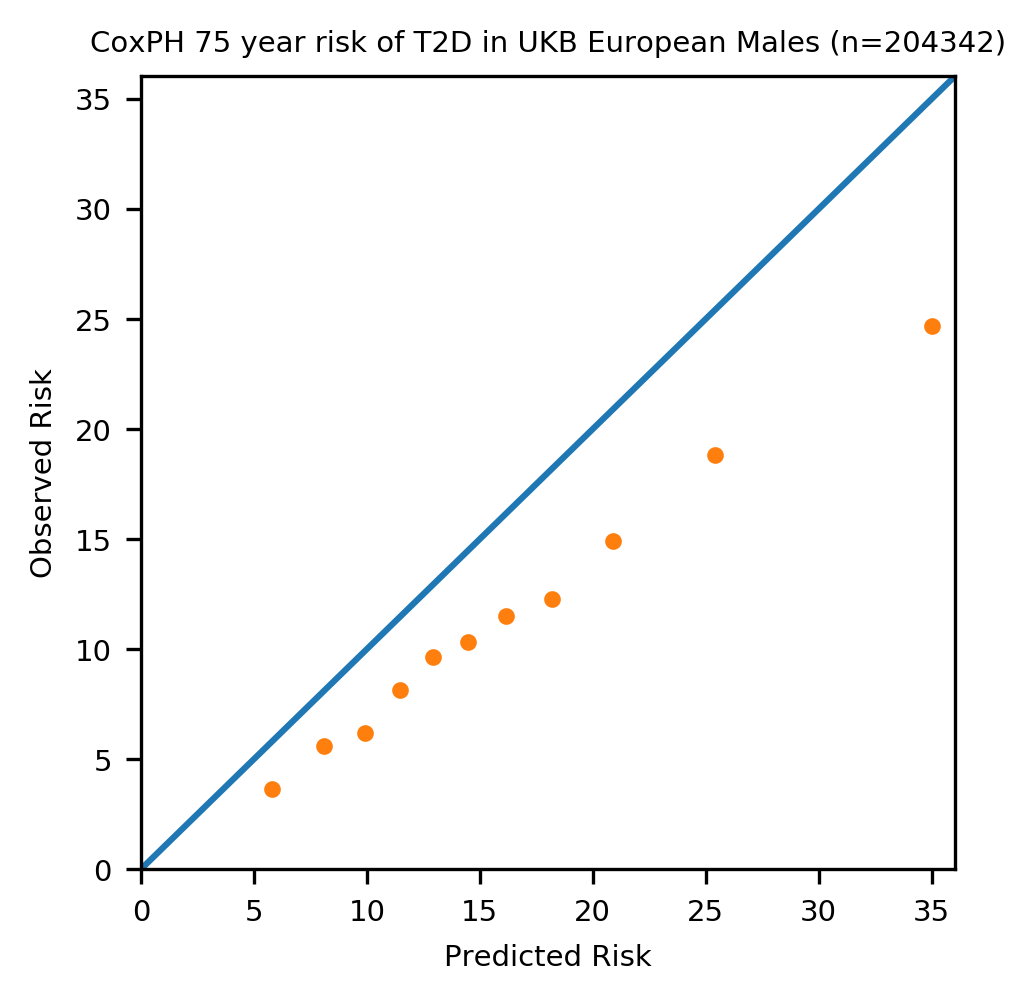

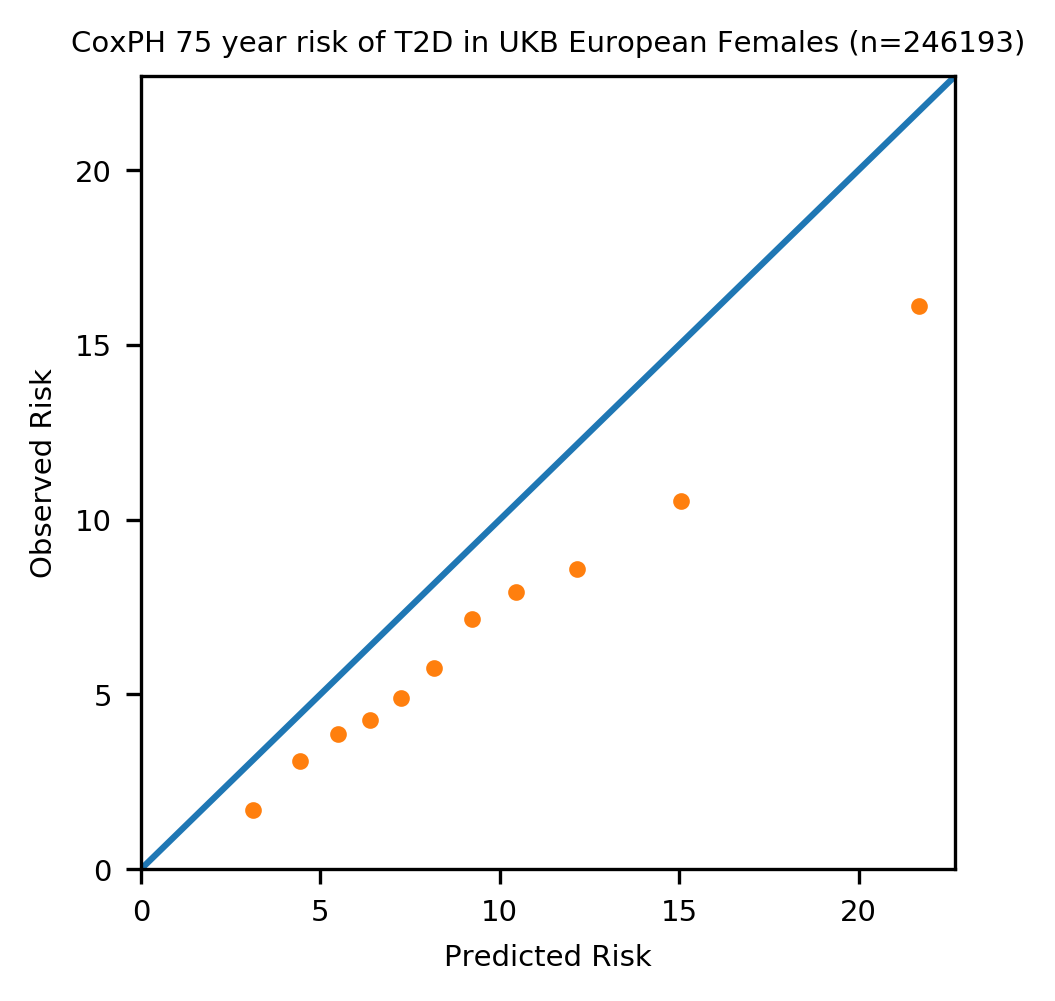

In [257]:
#Male
baseline_male_eur_full = 0.1563216
baseline_age_male_eur_full = 75.00

apply_rcox_and_plot('eur_male_full', 0.855, baseline_age_male_eur_full, eur_data_male_full, "CoxPH 75 year risk of T2D in UKB European Males (n=204342)"  )


#Female
baseline_female_eur_full = 0.08555524
baseline_age_female_eur_full = 75.00

apply_rcox_and_plot('eur_female_full', 0.918, baseline_age_female_eur_full, eur_data_female_full, "CoxPH 75 year risk of T2D in UKB European Females (n=246193)"  )


# East Asian RCOX Model

In [262]:
eas_data_male.shape

(565, 15)

geno_array_x    0.109573
pca1_x          1.097808
pca2_x         -0.068349
pca3_x          0.719928
pca4_x          0.037882
prs             0.085507
Name: x, dtype: float64
geno_array_x    0.091329
pca1_x         -0.104825
pca2_x         -0.322561
pca3_x          0.174200
pca4_x          0.092902
prs             0.080037
Name: x, dtype: float64


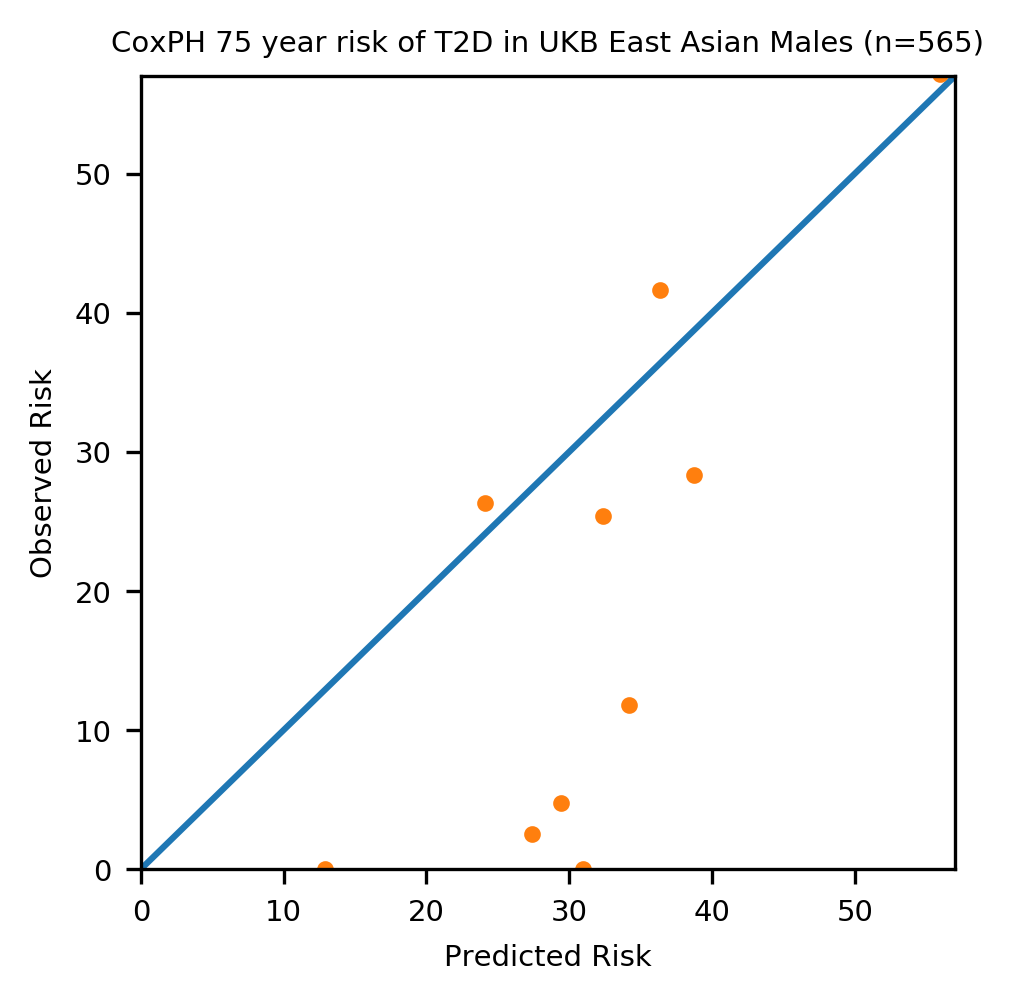

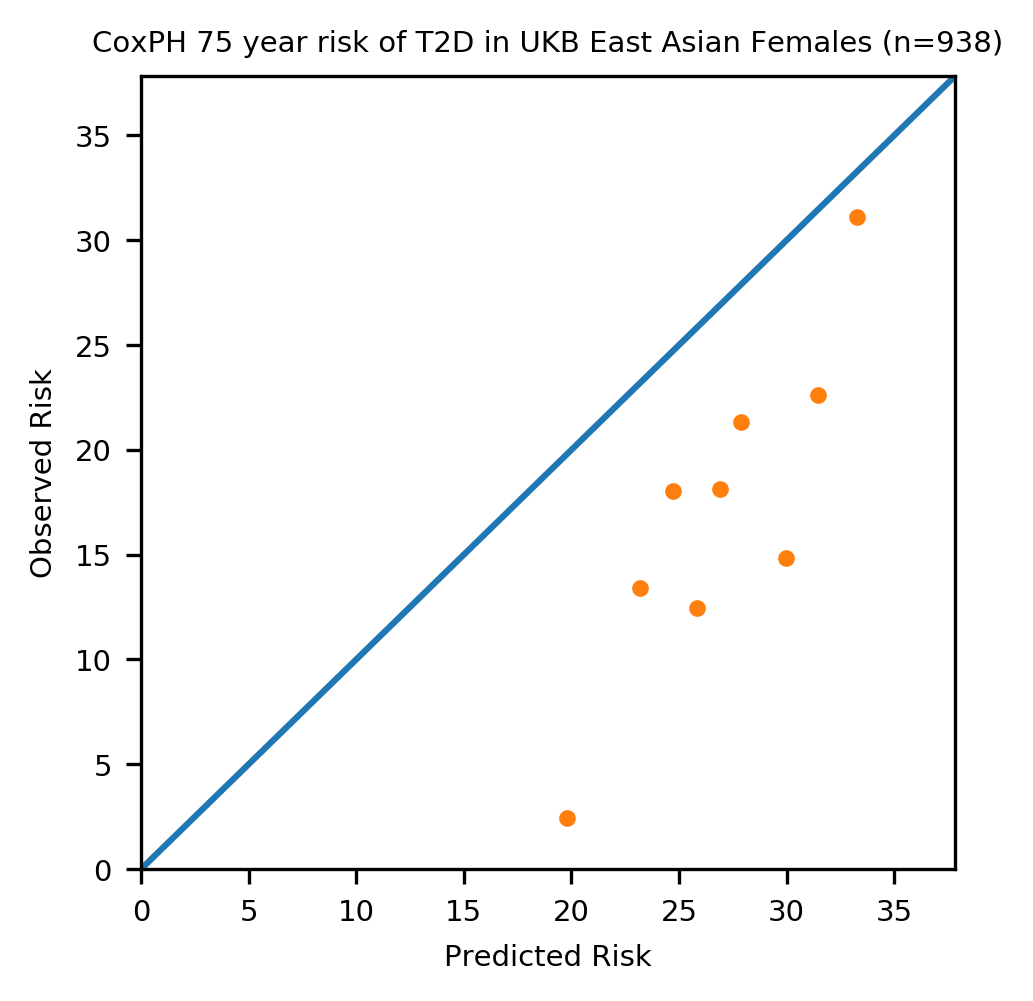

In [263]:
#Male
baseline_male_eas = 0.3203210
baseline_age_male_eas = 75.0125958

apply_rcox_and_plot('eas_male', 0.687, baseline_age_male_eas, eas_data_male, "CoxPH 75 year risk of T2D in UKB East Asian Males (n=565)"  )


#Female
baseline_female_eas = 0.2786245 #
baseline_age_female_eas = 75.0531216

apply_rcox_and_plot('eas_female', 0.722, baseline_age_female_eas, eas_data_female, "CoxPH 75 year risk of T2D in UKB East Asian Females (n=938)"  )


# South Asian RCOX Model

In [266]:
sas_data_female.shape

(4336, 15)

geno_array_x   -0.029763
pca1_x          0.035510
pca2_x          0.144581
pca3_x          0.071298
pca4_x          0.077657
prs             0.234010
Name: x, dtype: float64
geno_array_x   -0.003922
pca1_x         -0.107841
pca2_x          0.105155
pca3_x          0.154545
pca4_x          0.042312
prs             0.346437
Name: x, dtype: float64


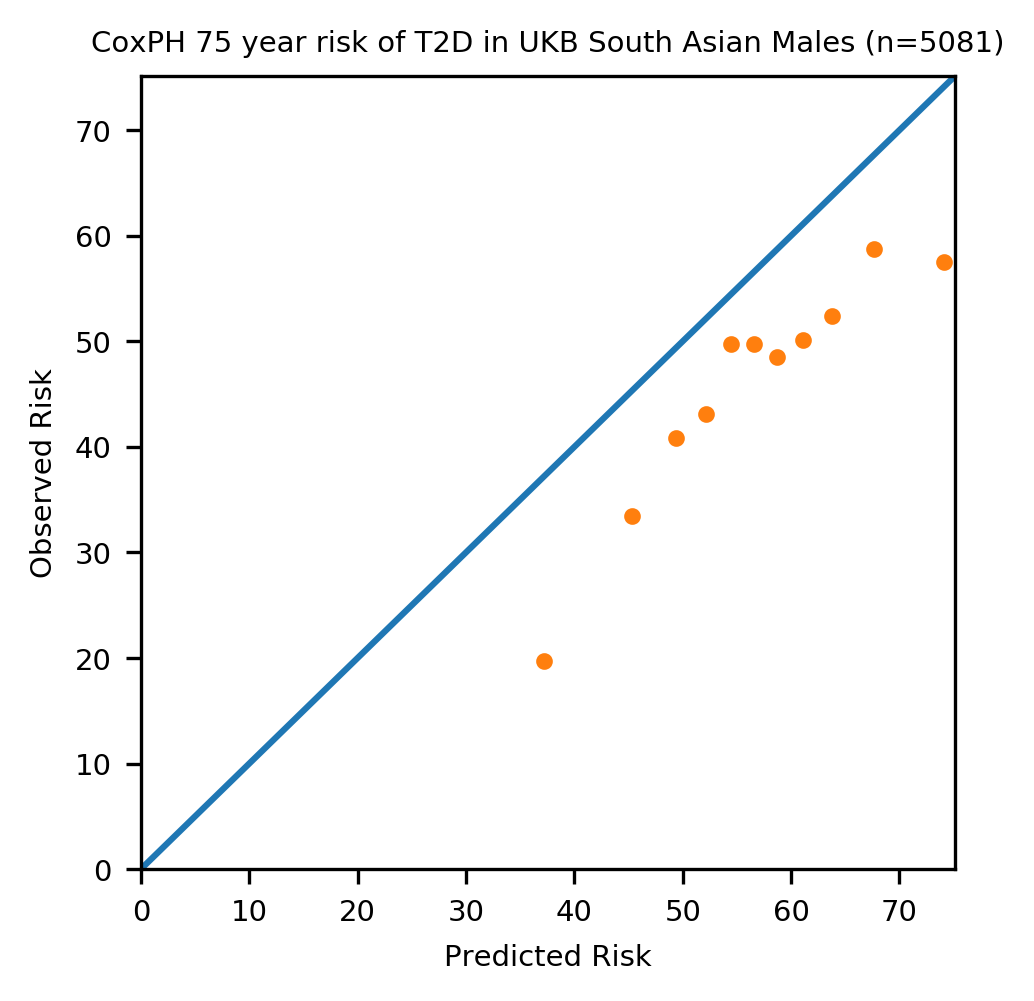

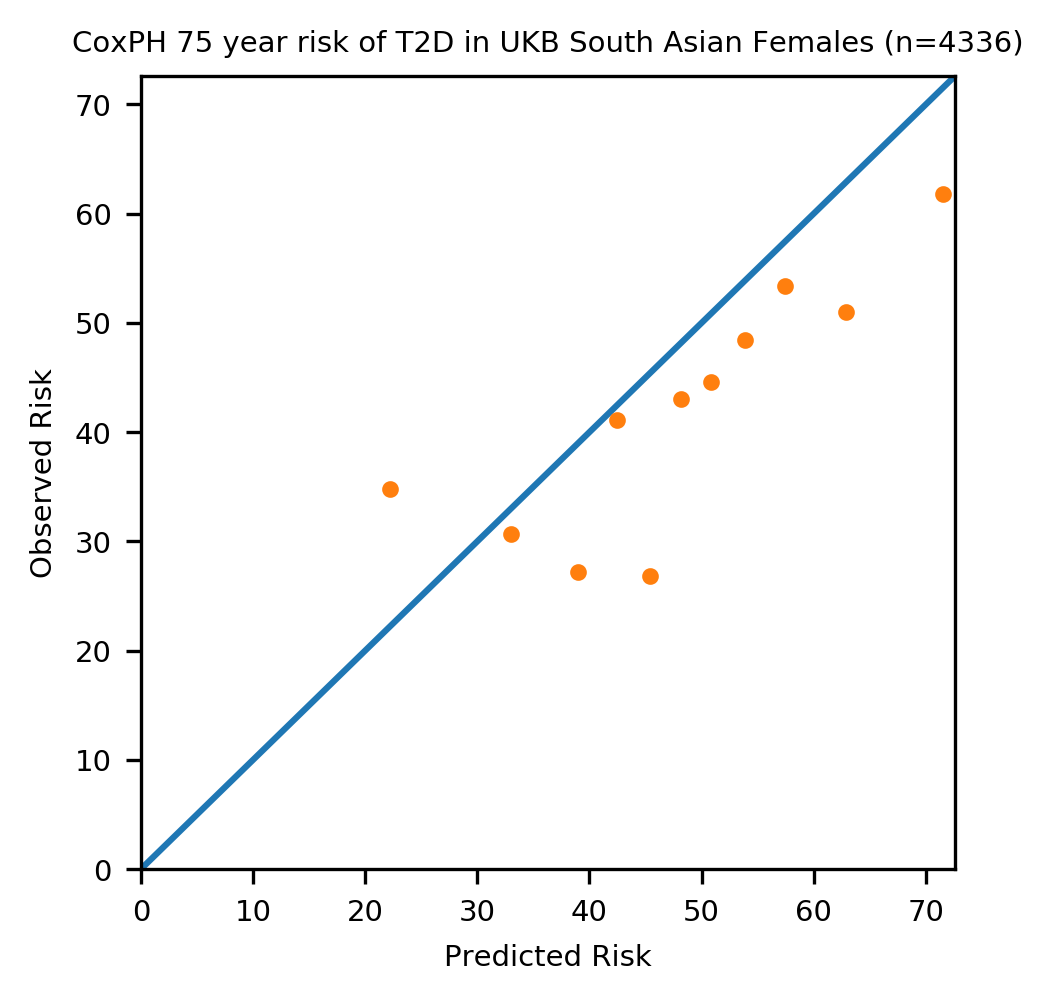

In [267]:
#Male
baseline_male_sas = 0.8298951
baseline_age_male_sas = 75.0169770

apply_rcox_and_plot('sas_male', 0.4373, baseline_age_male_sas, sas_data_male, "CoxPH 75 year risk of T2D in UKB South Asian Males (n=5081)"  )

#Female
baseline_female_sas = 0.6328648
baseline_age_female_sas = 75.0120482

apply_rcox_and_plot('sas_female', 0.528, baseline_age_female_sas, sas_data_female, "CoxPH 75 year risk of T2D in UKB South Asian Females (n=4336)"  )



# African RCox Model

In [269]:
afr_data_female.shape

(4363, 15)

geno_array_x   -0.049616
pca1_x          0.077487
pca2_x         -0.019658
pca3_x          0.134201
pca4_x         -0.093425
prs             0.147559
Name: x, dtype: float64
geno_array_x   -0.059873
pca1_x         -0.145700
pca2_x         -0.006898
pca3_x          0.080812
pca4_x          0.050377
prs             0.349870
Name: x, dtype: float64


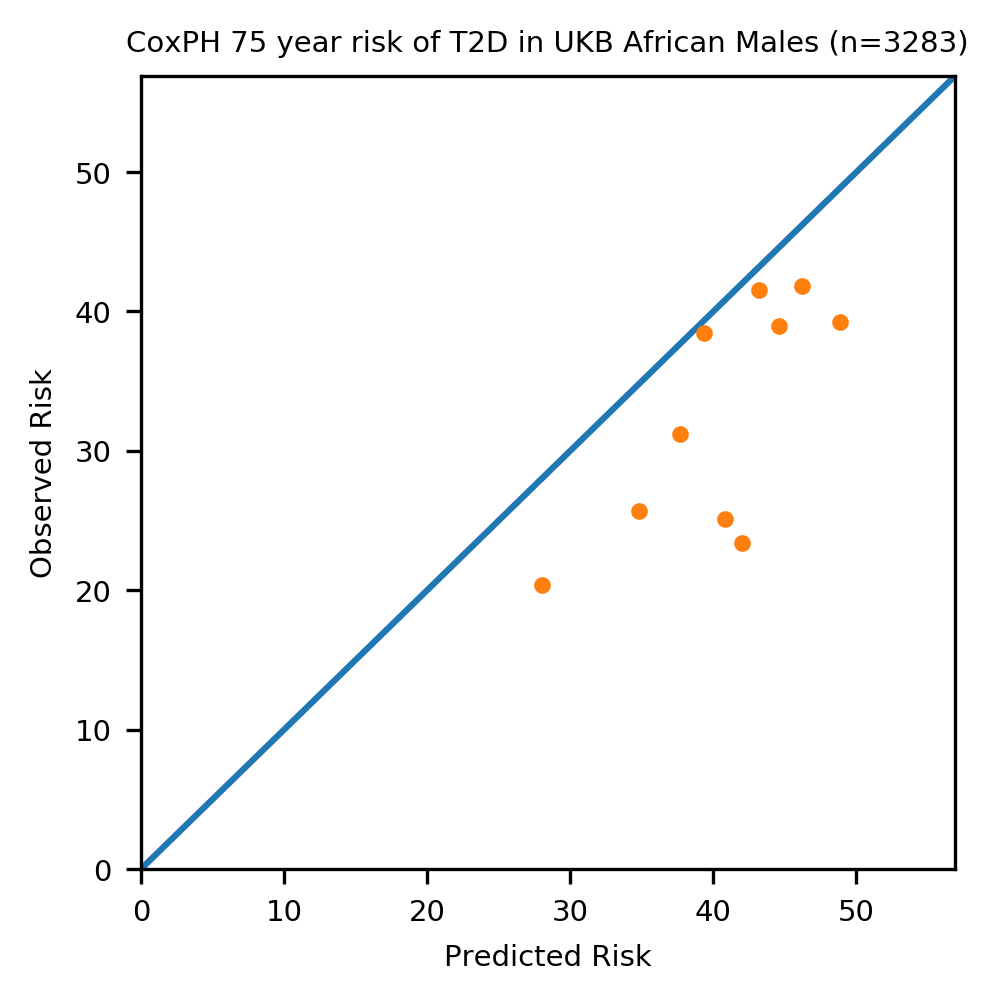

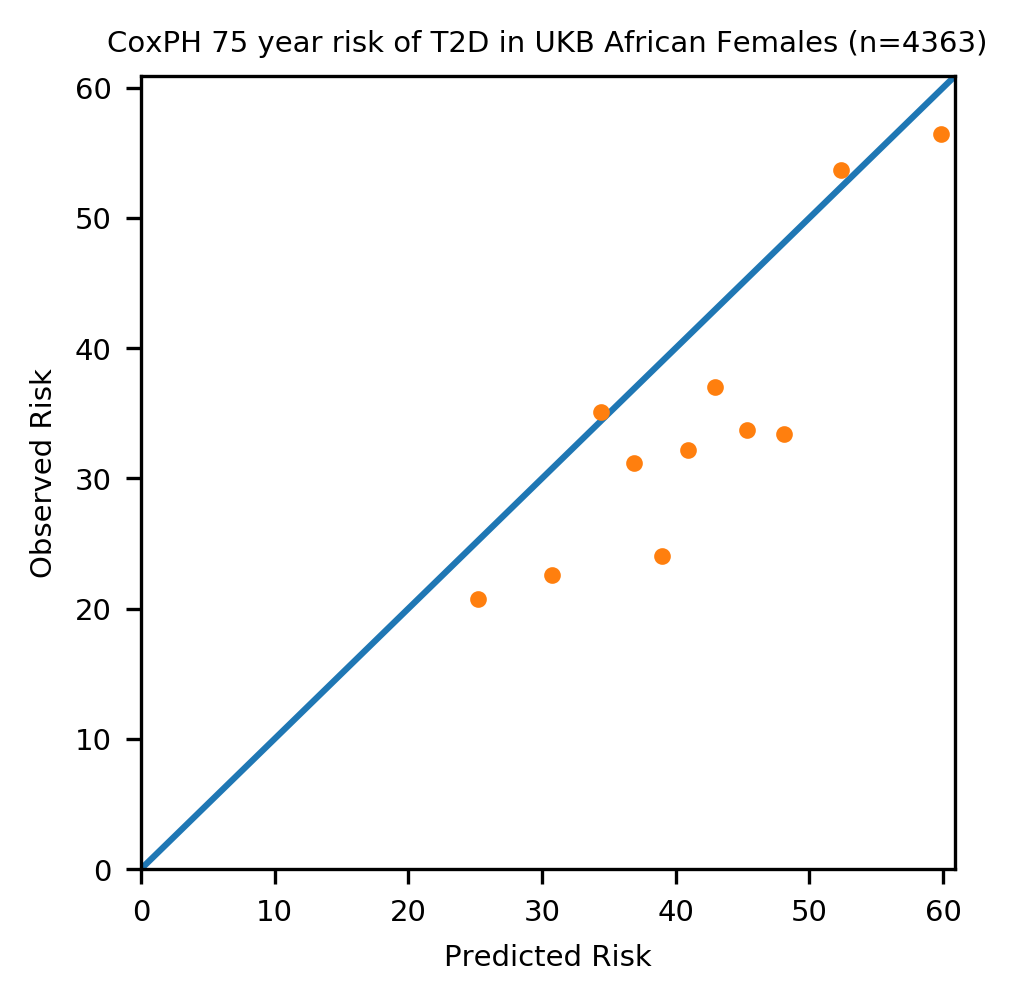

In [271]:
#Male
baseline_male_afr = 0.5390815
baseline_age_male_afr = 75.0071194

apply_rcox_and_plot('afr_male', 0.5833, baseline_age_male_afr, afr_data_male, "CoxPH 75 year risk of T2D in UKB African Males (n=3283)"  )


#Female
baseline_female_afr = 0.519434
baseline_age_female_afr = 75.030668

apply_rcox_and_plot('afr_female', 0.592, baseline_age_female_afr, afr_data_female, "CoxPH 75 year risk of T2D in UKB African Females (n=4363)"  )

# EUR RCox Model

In [ ]:
#Male
baseline_male_eur = 0.15485
baseline_age_male_eur = 75.00055

apply_rcox_and_plot('eur_male', 1 - baseline_male_eur, baseline_age_male_eur, eur_data_male, "EUR Male RCox"  )


#Female
baseline_female_eur = 0.09041067
baseline_age_female_eur = 75.00054765

apply_rcox_and_plot('eur_female', 1 - baseline_female_eur, baseline_age_female_eur, eur_data_female, "EUR Female RCox"  )

# Admixed Data & Cox Model - Python

In [272]:
#Getting the Admixed data and Joining it with all the data
admixed = get_ancestry()

admixed_pop =admixed.join(dataset)
admixed_pop = admixed_pop.join(pd.DataFrame(prs))

#Renaming columns
admixed_pop['prs'] = admixed_pop[0]
admixed_pop.rename(columns = {'affected':'affected', 'geno_array':'geno_array_x', 'pca1':'pca1_x', 'pca2':'pca2_x', 'pca3':'pca3_x', 'pca4':'pca4_x'}, inplace = True)

admixed_pop.head()


,AFR,AMR,EAS,EUR,SAS,earliest_date,first_visit_date,is_incident,pheno,time,...,age_disease,pca1_x,pca2_x,pca3_x,pca4_x,geno_array_x,affected,cause,0,prs
1000911,0.0000,0.0507,0.4750,0.4743,0.0000,2017-03-31 00:00:00,2010-02-06,NaN,0,2610.0,...,59.146769,75.2005,-133.46000,-63.8941,-5.49552,82.0,0,NaN,0.243829,0.243829
1003367,0.2542,0.0000,0.0000,0.7458,0.0000,2017-03-31 00:00:00,2009-06-02,NaN,0,2859.0,...,55.828587,100.0340,12.71090,12.0815,-65.11880,2.0,0,NaN,0.887605,0.887605
1004099,0.0000,0.0000,0.0000,0.6773,0.3227,2017-03-31 00:00:00,2010-06-21,NaN,0,2475.0,...,54.777108,21.0492,-38.74050,35.5808,3.18134,3.0,0,NaN,-0.557988,-0.557988
1007740,0.0835,0.0000,0.0000,0.8360,0.0805,2017-03-31 00:00:00,2009-09-17,NaN,0,2752.0,...,59.535597,35.2482,-5.27578,14.4238,-38.56850,79.0,0,NaN,0.110397,0.110397
1012484,0.2148,0.0000,0.5119,0.2732,0.0000,2017-03-31 00:00:00,2008-03-05,NaN,0,3313.0,...,74.071742,166.5870,-119.96600,-74.4332,-7.61184,35.0,0,NaN,1.085117,1.085117


In [273]:
admixed_pop.affected.value_counts()

0    924
1     72
Name: affected, dtype: int64

In [274]:
#Standardizing the Admixed Pop Data
#admixed_pop = standardize(admixed_pop,['prs','geno_array_x','pca1_x','pca2_x','pca3_x','pca4_x'])

#Joining Gender
admixed_pop = admixed_pop.join(gender)

#Removing Prevalance Cases
admixed_pop = admixed_pop[admixed_pop['time']>0]
admixed_pop.shape



(996, 22)

In [275]:
#Removing unused columns
admixed_pop.drop(columns=['earliest_date','first_visit_date','cause','is_incident'], inplace=True)


#Removing NA rows
admixed_pop = admixed_pop.dropna()

admixed_pop.shape

(996, 18)

In [276]:
def get_male_female_split(df, anc):
    
    data_male = df[df['gender']==1]
    data_female = df[df['gender']==0]
    
  
    if anc == 'eur':
        data_male = df[df['gender']==1].sample(20000, random_state=1)
        data_female = df[df['gender']==0].sample(20000, random_state=1)
    
    #Standardize individual ancestry data
    std_data_male = standardize(data_male,['prs','geno_array_x','pca1_x','pca2_x','pca3_x','pca4_x'])
    std_data_female = standardize(data_female,['prs','geno_array_x','pca1_x','pca2_x','pca3_x','pca4_x'])
    
    std_data_male.to_csv(anc+'_data_male.csv')
    std_data_female.to_csv(anc+'_data_female.csv')
    
    return std_data_male, std_data_female

In [277]:
admixed_data_male, admixed_data_female = get_male_female_split(admixed_pop,'admixed')


In [280]:
admixed_data_female.shape

(626, 18)

geno_array_x   -0.120708
pca1_x         -0.502847
pca2_x         -0.083573
pca3_x          0.225347
pca4_x          0.343194
prs             0.441801
Name: x, dtype: float64
geno_array_x    0.072489
pca1_x         -0.545607
pca2_x          0.103960
pca3_x          0.127012
pca4_x          0.629236
prs             0.557235
Name: x, dtype: float64


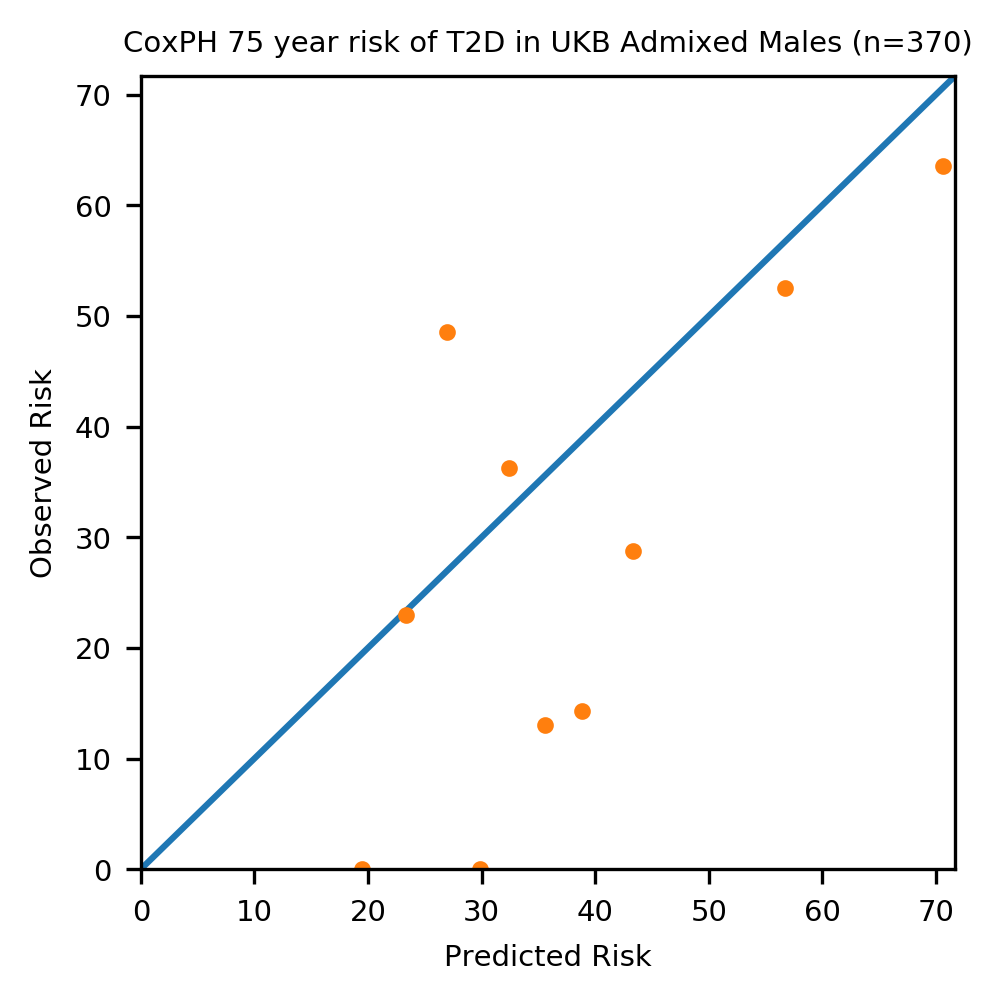

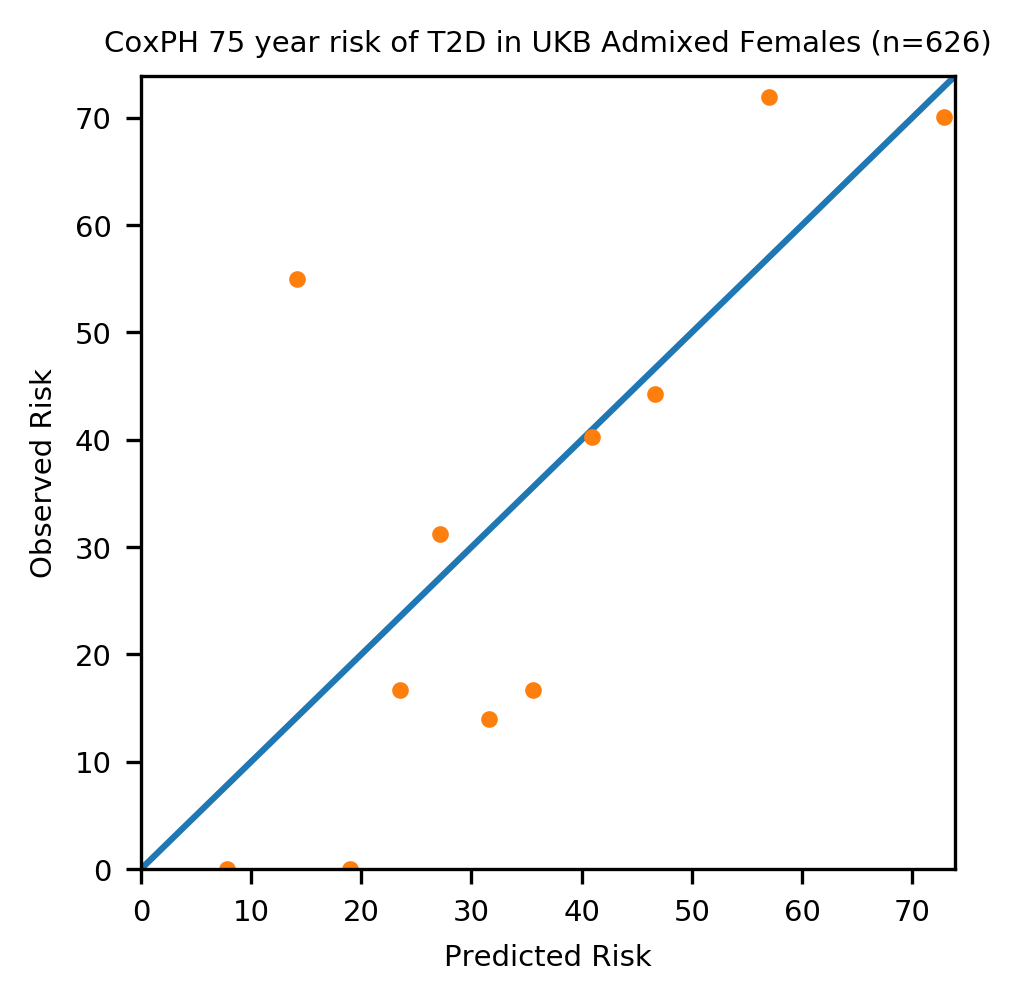

In [281]:
#Male
#baseline_male_admixed = 0.460342
#baseline_age_male_admixed = 75.007119

apply_rcox_and_plot('admixed_male', 0.631, baseline_age_male_admixed, admixed_data_male, "CoxPH 75 year risk of T2D in UKB Admixed Males (n=370)"  )


#Female
baseline_female_admixed = 0.3634771
baseline_age_female_admixed = 75.2179628

apply_rcox_and_plot('admixed_female',  0.695, baseline_age_female_admixed, admixed_data_female, "CoxPH 75 year risk of T2D in UKB Admixed Females (n=626)"  )



# META FUSE CODE

Data Preprocess and pass to Metafusion Model in R

In [282]:
#Preprocess the data for metafuse
def preprocess_metafuse(df, group):
    columns_needed = ['age_disease','affected','pca1_x','pca2_x','pca3_x','pca4_x','geno_array_x','prs','gender']
    df_metafuse = df[columns_needed]
    df_metafuse['group'] = group
    
    return df_metafuse



#Preprocess the data for compare risk
def compare_risk_data(metafuse_risk, cox_risk, cox75, full_data):
    compare_risk = metafuse_risk.join(cox_risk[0][cox75])
    compare_risk = compare_risk.join(full_data.affected)
    compare_risk.columns = ['mfuse_risk','cox_risk','affected']
    return compare_risk


def plot_altair(df,title,trait='affected'):
    
    alt.data_transformers.disable_max_rows()

    m = alt.Chart(df, title=title).mark_circle(size=5).encode(
    alt.Y('cox_risk', title="COX Risk"),
    alt.X('mfuse_risk', title="Metafuse Risk"),
    color=alt.Color('{}:N'.format(trait),scale=alt.Scale(range=['silver','red']))).properties(
        width=400,
        height=400
    )
    r = list(np.arange(0,1,.1))
    b = pd.DataFrame.from_dict({'x': r,'y':r})
    l = alt.Chart(b).mark_line().encode(
    alt.X('x'),alt.Y('y')
    )
    
    return (m + l)


In [283]:
#Calling the preprocess function

eur_data_metafuse_male = preprocess_metafuse(eur_data_male,1)
eur_data_metafuse_female = preprocess_metafuse(eur_data_female,1)


sas_data_metafuse_male = preprocess_metafuse(sas_data_male,2)
sas_data_metafuse_female = preprocess_metafuse(sas_data_female,2)


afr_data_metafuse_male = preprocess_metafuse(afr_data_male,3)
afr_data_metafuse_female = preprocess_metafuse(afr_data_female,3)

eas_data_metafuse_male = preprocess_metafuse(eas_data_male,4)
eas_data_metafuse_female = preprocess_metafuse(eas_data_female,4)


#admixed_data_metafuse = preprocess_metafuse(admixed_pop,5)

In [284]:
#Merge all the dataframes for each ancestry into one file with groups
metafuse_data_male = pd.concat([eur_data_metafuse_male, sas_data_metafuse_male, afr_data_metafuse_male, eas_data_metafuse_male])

metafuse_data_female = pd.concat([eur_data_metafuse_female, sas_data_metafuse_female, afr_data_metafuse_female, eas_data_metafuse_female])


In [285]:
metafuse_data_male.shape, metafuse_data_female.shape

((28929, 10), (29637, 10))

In [286]:
metafuse_data_male.group.value_counts(), metafuse_data_female.group.value_counts(), 

(1    20000
 2     5081
 3     3283
 4      565
 Name: group, dtype: int64,
 1    20000
 3     4363
 2     4336
 4      938
 Name: group, dtype: int64)

In [303]:
metafuse_data_male

,age_disease,affected,pca1_x,pca2_x,pca3_x,pca4_x,geno_array_x,prs,group
eid,,,,,,,,,
2231786,70.433735,0,-0.197650,0.241189,-0.753609,0.256983,-1.493322,0.308163,1
1005876,69.693866,0,-0.266478,0.507787,-0.307877,0.312060,0.940394,-1.713925,1
2762099,68.944140,0,-0.186953,-0.390972,-0.057354,1.108766,1.297339,0.691853,1
5840068,55.804491,0,-0.247333,-0.146102,-0.016270,-0.231799,1.102642,0.092780,1
5888762,70.758488,1,-0.544716,0.276621,-0.598672,0.244969,1.232440,-0.220737,1
...,...,...,...,...,...,...,...,...,...
3088214,72.628149,0,-0.152723,-0.103717,-0.108390,0.220442,-1.527971,-0.248322,4
2684686,56.693866,0,0.358412,-0.195540,-0.205259,-0.005000,0.836248,-0.747186,4
1175384,78.679628,0,0.320254,-0.248917,-0.136581,-1.766713,0.363404,1.792838,4


In [287]:
#Dropping the irrevant gender column
metafuse_data_male.drop(columns='gender', inplace=True)
metafuse_data_female.drop(columns='gender', inplace=True)

In [288]:
#Saving the csv file anf passing it to R script for metafuse model

metafuse_data_male.to_csv("metafuse_data_male.csv")
metafuse_data_female.to_csv("metafuse_data_female.csv")



Applying the Metafuse

In [289]:
def get_metafuse_beta(sex):
    metafuse_beta = pd.read_csv("metafsue_beta_"+sex+".csv")
    eur_metafuse_beta = metafuse_beta[:1]
    sas_metafuse_beta = metafuse_beta[1:2]
    afr_metafuse_beta = metafuse_beta[2:3]
    eas_metafuse_beta = metafuse_beta[3:4]
    
    eur_metafuse_beta = pd.Series( {e:eur_metafuse_beta[e].values[0] for e in eur_metafuse_beta if e != 'Unnamed: 0'} )
    sas_metafuse_beta = pd.Series( {e:sas_metafuse_beta[e].values[0] for e in sas_metafuse_beta if e != 'Unnamed: 0'} )
    afr_metafuse_beta = pd.Series( {e:afr_metafuse_beta[e].values[0] for e in afr_metafuse_beta if e != 'Unnamed: 0'} )
    eas_metafuse_beta = pd.Series( {e:eas_metafuse_beta[e].values[0] for e in eas_metafuse_beta if e != 'Unnamed: 0'} )
    
    return eur_metafuse_beta, sas_metafuse_beta, afr_metafuse_beta, eas_metafuse_beta

In [290]:
#Metafuse Beta for Male
eur_metafuse_beta_male, sas_metafuse_beta_male, afr_metafuse_beta_male, eas_metafuse_beta_male = get_metafuse_beta("male")

In [291]:
#Metafuse Beta for Female
eur_metafuse_beta_female, sas_metafuse_beta_female, afr_metafuse_beta_female, eas_metafuse_beta_female = get_metafuse_beta("female")

In [310]:
eas_metafuse_beta_male

pca1_x          0.784653
pca2_x          0.019666
pca3_x          0.440333
pca4_x          0.058447
geno_array_x    0.060920
prs             0.101091
dtype: float64

In [312]:
eas_metafuse_beta_female

pca1_x         -0.032652
pca2_x         -0.109957
pca3_x          0.082170
pca4_x          0.060496
geno_array_x    0.028203
prs             0.113264
dtype: float64

In [ ]:
##IMP
'''
#Individual Ancestry Baseline
baseline_eur_rcox = 1 - baseline_male_eur
baseline_sas_rcox = 1- baseline_male_sas
baseline_afr_rcox = 1 - baseline_male_afr
baseline_eas_rcox = 1- baseline_male_eas
'''

In [ ]:
baseline_male_eur

In [313]:
#Individual Ancestry Baseline
baseline_eur_rcox_male = 0.855
baseline_sas_rcox_male = 0.4373
baseline_afr_rcox_male = 0.5833
baseline_eas_rcox_male = 0.687

baseline_eur_rcox_female = 0.918
baseline_sas_rcox_female = 0.528
baseline_afr_rcox_female = 0.592
baseline_eas_rcox_female = 0.722

In [ ]:
'''
#Male
one_baseline_male = 1 - baseline_male_eur_full 

#Female
one_baseline_female = 1 - baseline_female_eur_full 

'''
baseline_female_eur_full = 0.08555524
baseline_age_female_eur_full = 75.00
baseline_age_male_eur_full = 75.00
'''
one_baseline_male, one_baseline_female

'''

In [314]:
#Metafuse Risk for MALE

metafuse_eur_risk_male = apply_metafuse(eur_data_metafuse_male.drop(columns=['affected','group','age_disease']), eur_metafuse_beta_male, baseline_eur_rcox_male)
metafuse_sas_risk_male = apply_metafuse(sas_data_metafuse_male.drop(columns=['affected','group','age_disease']), sas_metafuse_beta_male, baseline_sas_rcox_male)
metafuse_afr_risk_male = apply_metafuse(afr_data_metafuse_male.drop(columns=['affected','group','age_disease']), afr_metafuse_beta_male, baseline_afr_rcox_male)
metafuse_eas_risk_male = apply_metafuse(eas_data_metafuse_male.drop(columns=['affected','group','age_disease']), eas_metafuse_beta_male, baseline_eas_rcox_male)
#metafuse_admixed_risk = apply_metafuse(admixed_data_metafuse.drop(columns=['affected','group','age_disease']), admixed_metafuse_beta, baseline_eur)

In [315]:
#Metafuse Risk for FEMALE

metafuse_eur_risk_female = apply_metafuse(eur_data_metafuse_female.drop(columns=['affected','group','age_disease']), eur_metafuse_beta_female, baseline_eur_rcox_female)
metafuse_sas_risk_female = apply_metafuse(sas_data_metafuse_female.drop(columns=['affected','group','age_disease']), sas_metafuse_beta_female, baseline_sas_rcox_female)
metafuse_afr_risk_female = apply_metafuse(afr_data_metafuse_female.drop(columns=['affected','group','age_disease']), afr_metafuse_beta_female, baseline_afr_rcox_female)
metafuse_eas_risk_female = apply_metafuse(eas_data_metafuse_female.drop(columns=['affected','group','age_disease']), eas_metafuse_beta_female, baseline_eas_rcox_female)
#metafuse_admixed_risk = apply_metafuse(admixed_data_metafuse.drop(columns=['affected','group','age_disease']), admixed_metafuse_beta, baseline_eur)

In [318]:
metafuse_eur_risk_male_fd.shape

(20000, 11)

([2.7890801121726594,
  4.775419200310527,
  3.7423091502689187,
  5.661768687769442,
  6.702584309089565,
  6.370549696116557,
  6.717564223702233,
  8.266301544529565,
  9.210129169364933,
  10.196889185510127,
  12.646308423294572],
 [6.403184582311525,
  7.02538405355438,
  7.405409784919178,
  7.683761204916081,
  7.937838671953858,
  8.176085476651739,
  8.426733372582095,
  8.703163369387916,
  9.052826974757368,
  9.575710532029769,
  10.90450831669772])

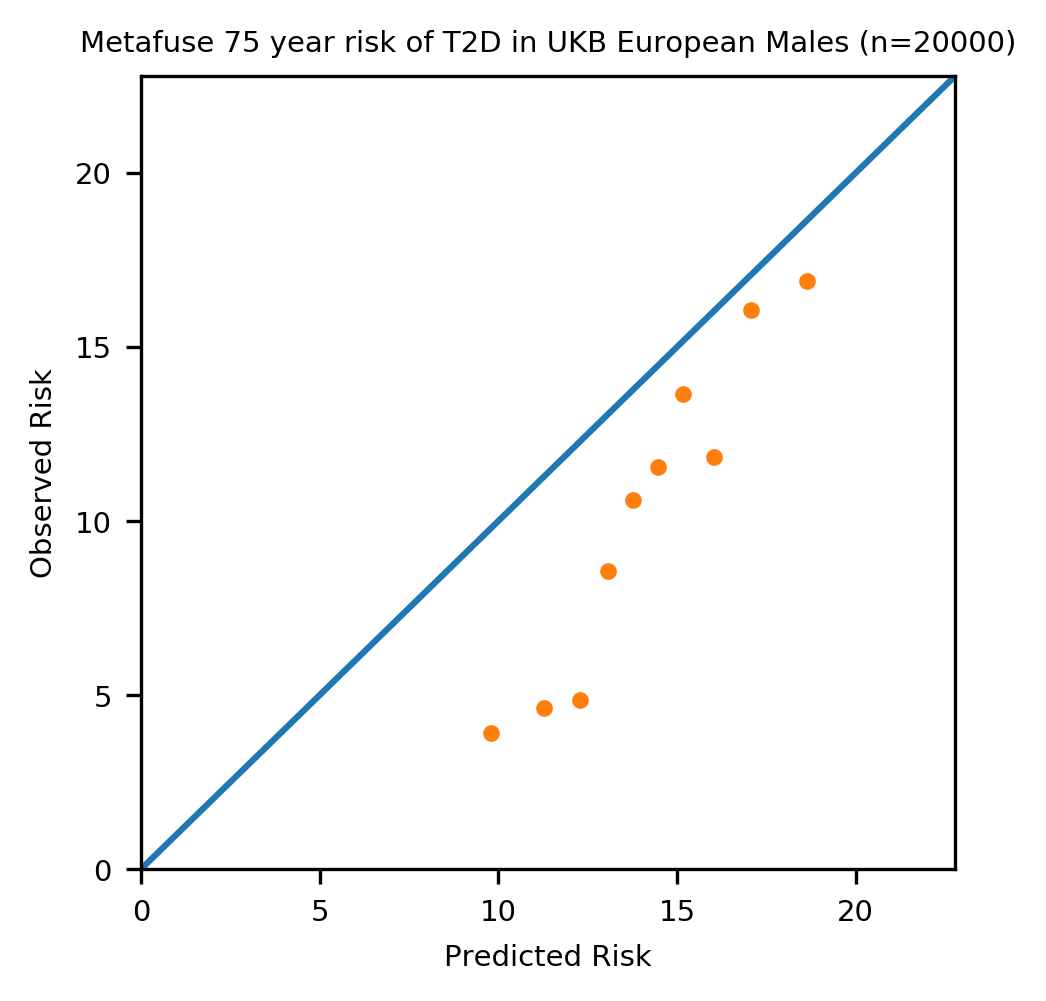

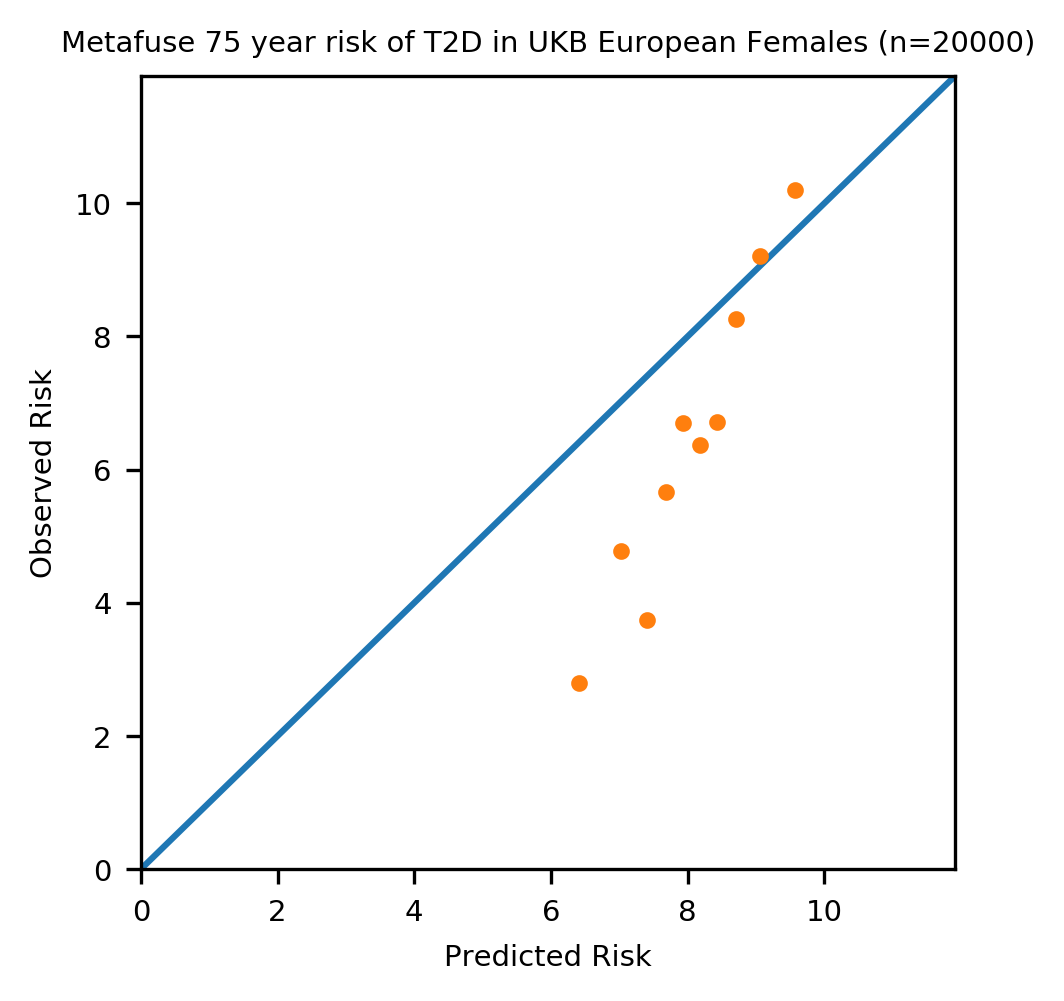

In [319]:
metafuse_eur_risk_male_fd = metafuse_eur_risk_male.join(eur_data_metafuse_male)

plot_calibration_km_rcox123(metafuse_eur_risk_male_fd.mfuse_risk, metafuse_eur_risk_male_fd, 75, "Metafuse 75 year risk of T2D in UKB European Males (n=20000)", cens=3286.0, bins=10, col="age_disease", truncation=False)

metafuse_eur_risk_female_fd = metafuse_eur_risk_female.join(eur_data_metafuse_female)

plot_calibration_km_rcox123(metafuse_eur_risk_female_fd.mfuse_risk, metafuse_eur_risk_female_fd, 75, "Metafuse 75 year risk of T2D in UKB European Females (n=20000)", cens=3286.0, bins=10, col="age_disease", truncation=False)


In [322]:
metafuse_sas_risk_female.shape

(4336, 1)

([23.244254941392395,
  30.10940210947487,
  32.07043584176657,
  42.07454615598122,
  25.492264579752987,
  41.77879574365112,
  49.107462803195276,
  45.774568501835425,
  49.34708144244047,
  53.333662648705925,
  62.99256703512916],
 [3.795123688781575,
  25.96350293322141,
  37.16304232118926,
  42.7025514443571,
  47.20319671142476,
  51.87845880747416,
  56.30198367792152,
  61.096558574266645,
  66.88745097705036,
  75.17593002787825,
  86.25272669570558])

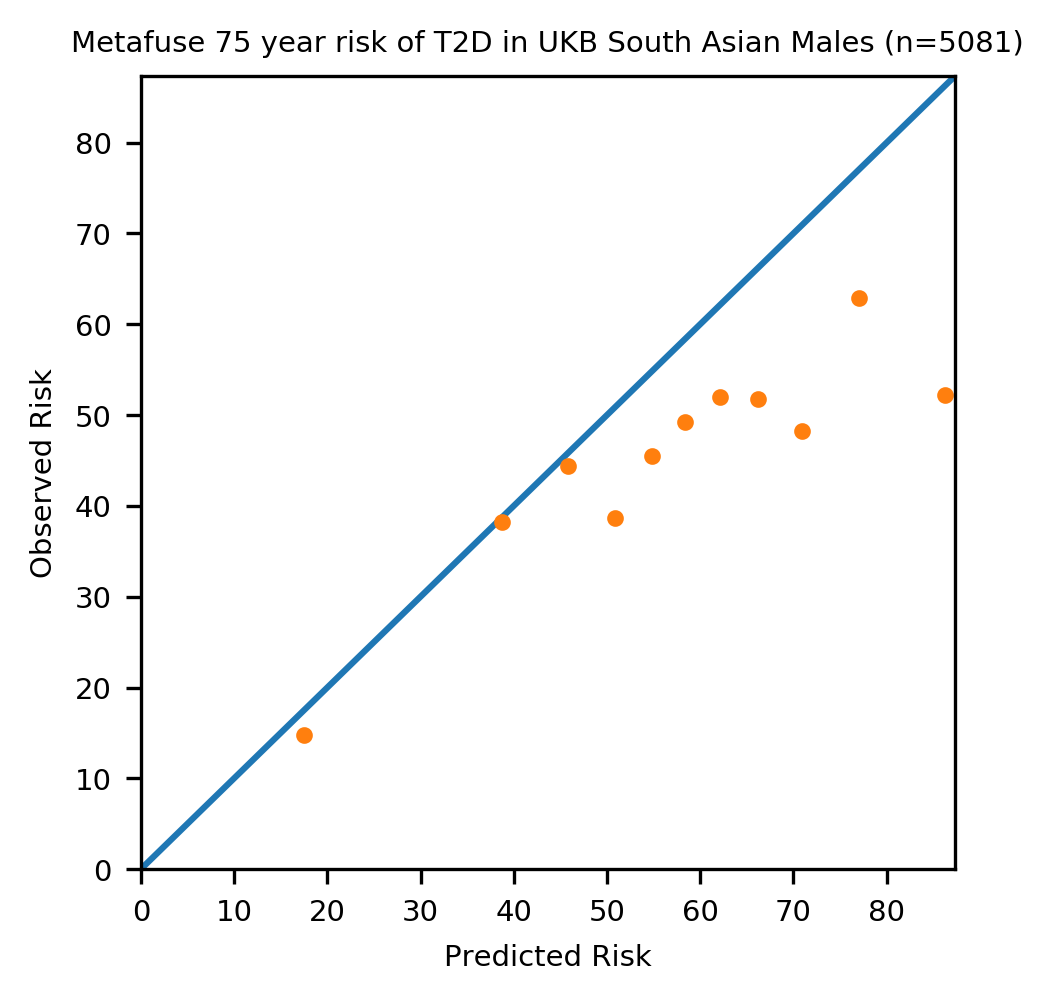

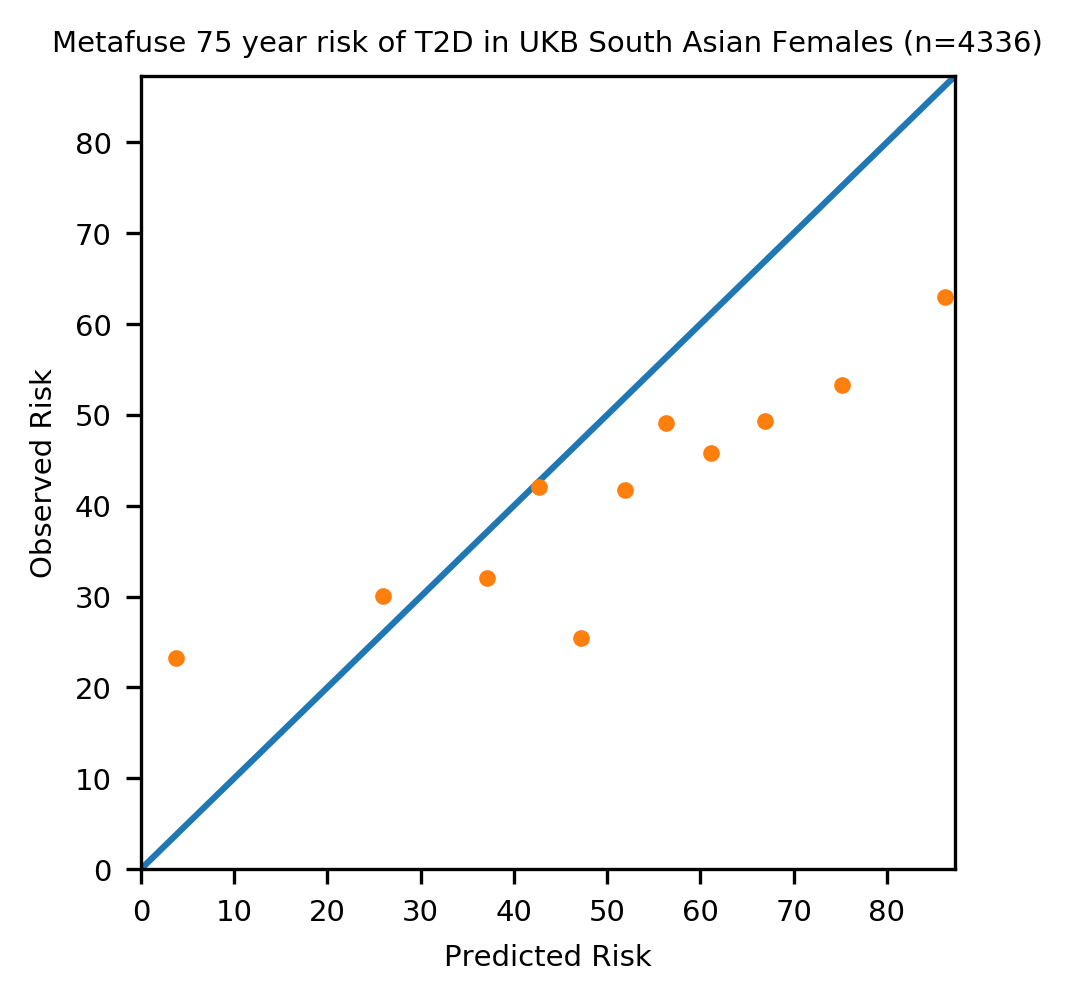

In [323]:
metafuse_sas_risk_male_fd = metafuse_sas_risk_male.join(sas_data_metafuse_male)

plot_calibration_km_rcox123(metafuse_sas_risk_male_fd.mfuse_risk, metafuse_sas_risk_male_fd, 75, "Metafuse 75 year risk of T2D in UKB South Asian Males (n=5081)", cens=3286.0, bins=10, col="age_disease", truncation=False)


metafuse_sas_risk_female_fd = metafuse_sas_risk_female.join(sas_data_metafuse_female)

plot_calibration_km_rcox123(metafuse_sas_risk_female_fd.mfuse_risk, metafuse_sas_risk_female_fd, 75, "Metafuse 75 year risk of T2D in UKB South Asian Females (n=4336)", cens=3286.0, bins=10, col="age_disease", truncation=False)


In [326]:
metafuse_afr_risk_female.shape

(4363, 1)

([24.93688039829629,
  26.608493028675817,
  21.334391771025363,
  31.36351815503009,
  34.15918264128194,
  36.473839695430286,
  23.40436362861932,
  35.80194744126409,
  38.396729745776916,
  52.412006031387236,
  53.799466197434285],
 [18.127720534103755,
  26.107505361511755,
  31.4136972446318,
  35.164800079849556,
  38.37175950517946,
  41.303748042099606,
  44.39321128251277,
  47.96067482226176,
  52.38488290745632,
  58.90141559359936,
  70.18674619009495])

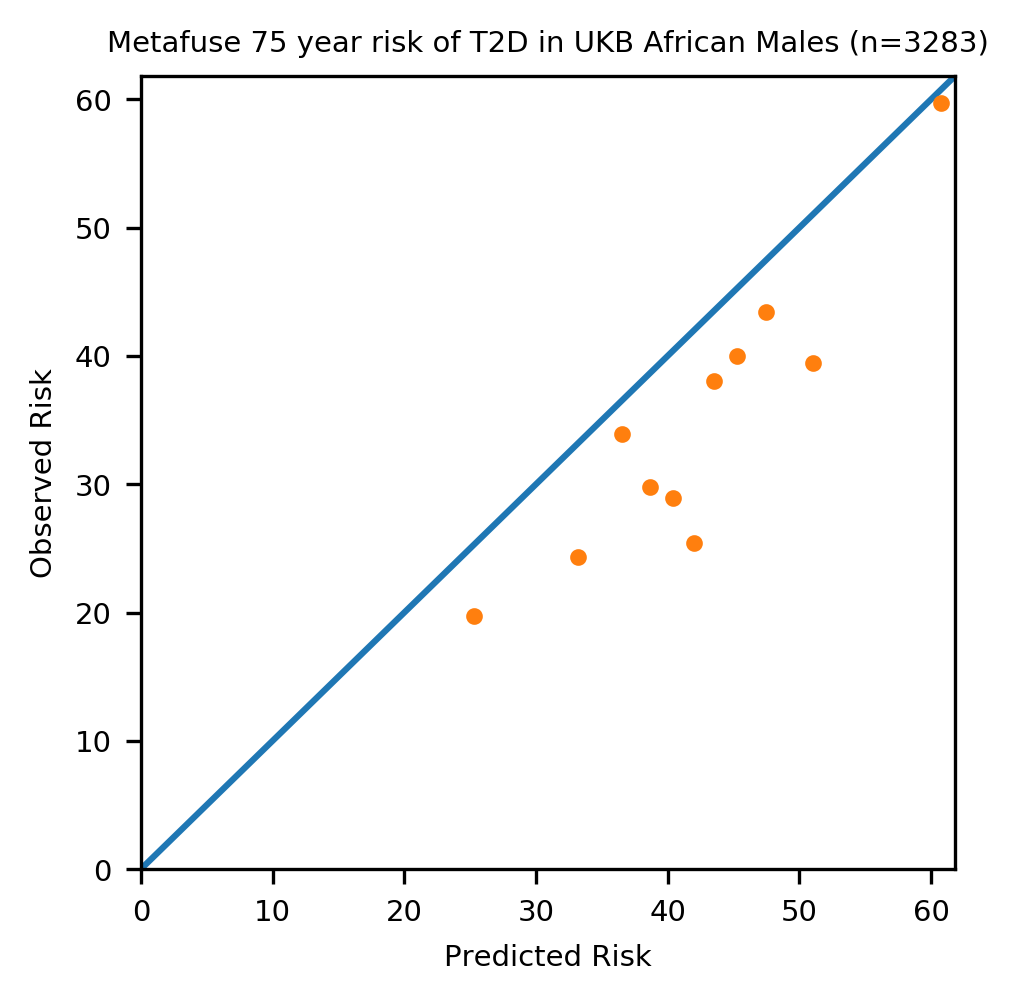

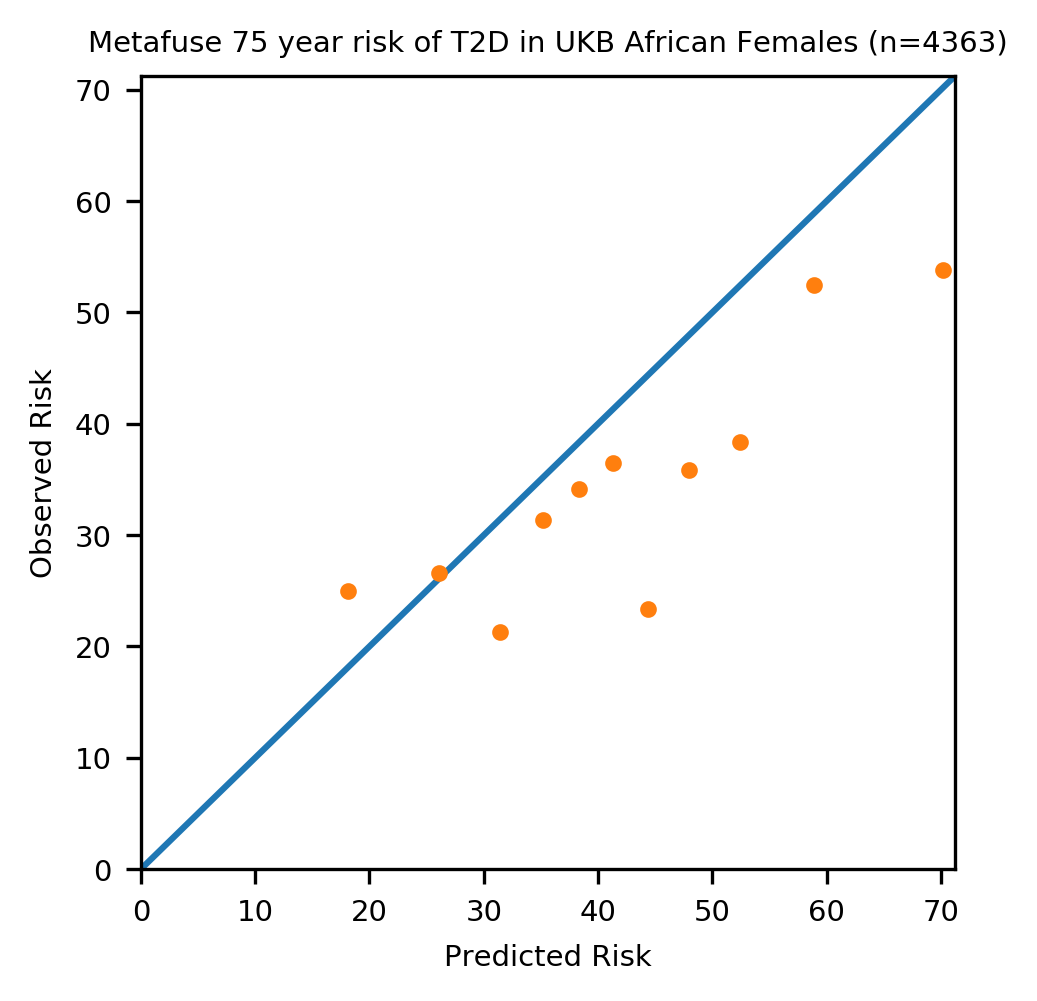

In [328]:
metafuse_afr_risk_male_fd = metafuse_afr_risk_male.join(afr_data_metafuse_male)

plot_calibration_km_rcox123(metafuse_afr_risk_male_fd.mfuse_risk, metafuse_afr_risk_male_fd, 75, "Metafuse 75 year risk of T2D in UKB African Males (n=3283)", cens=3286.0, bins=10, col="age_disease", truncation=False)


metafuse_afr_risk_female_fd = metafuse_afr_risk_female.join(afr_data_metafuse_female)

plot_calibration_km_rcox123(metafuse_afr_risk_female_fd.mfuse_risk, metafuse_afr_risk_female_fd, 75, "Metafuse 75 year risk of T2D in UKB African Females (n=4363)", cens=3286.0, bins=10, col="age_disease", truncation=False)

In [330]:
metafuse_eas_risk_female.shape

(938, 1)

([2.439024390243927,
  2.7027027027026973,
  10.3733146286338,
  33.79699685717606,
  22.60343822843821,
  17.816091954022983,
  27.67857142857141,
  26.069518716577512,
  27.957117331745096,
  25.485008818342138,
  47.36842105263158],
 [21.831899759440425,
  24.105524179908016,
  25.36127751252485,
  26.245004172727874,
  27.02517537571066,
  27.76223801165364,
  28.548565043094605,
  29.41689177221887,
  30.52887005844366,
  32.04322254354566,
  34.68890808900887])

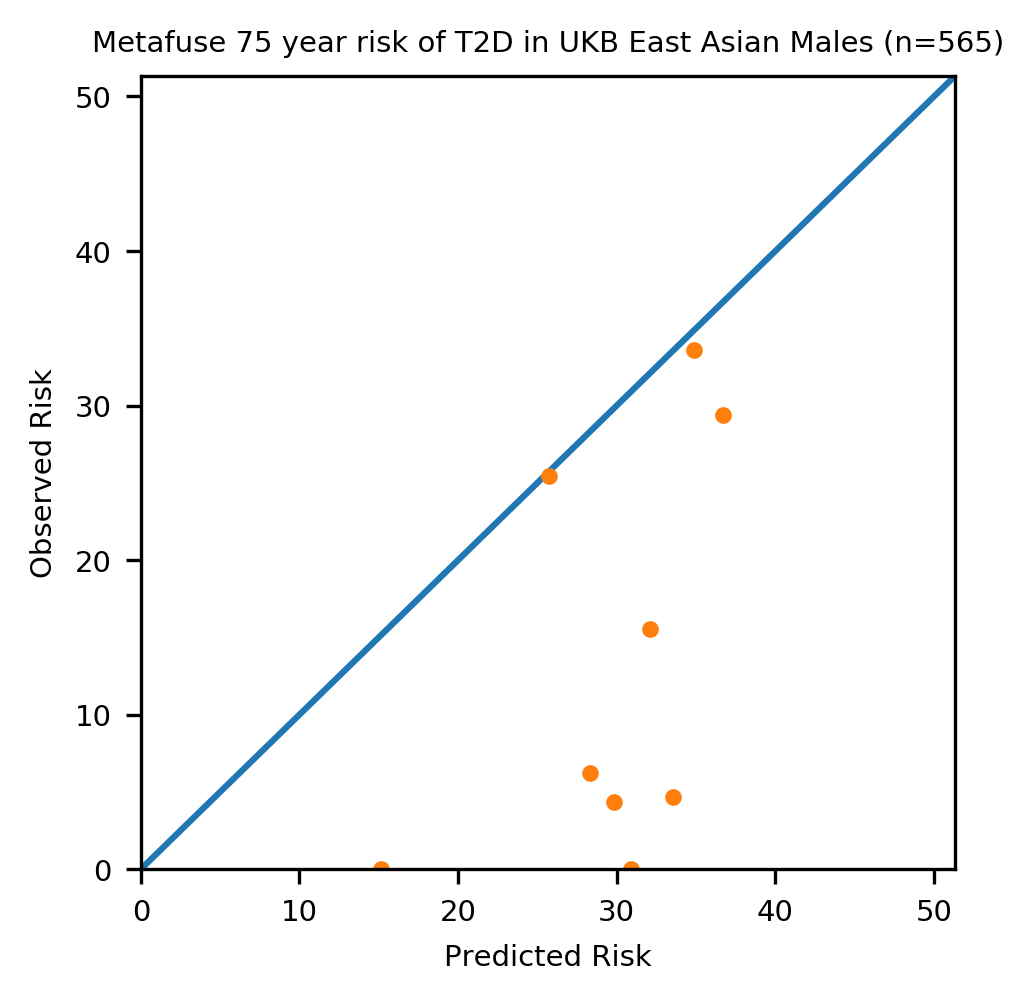

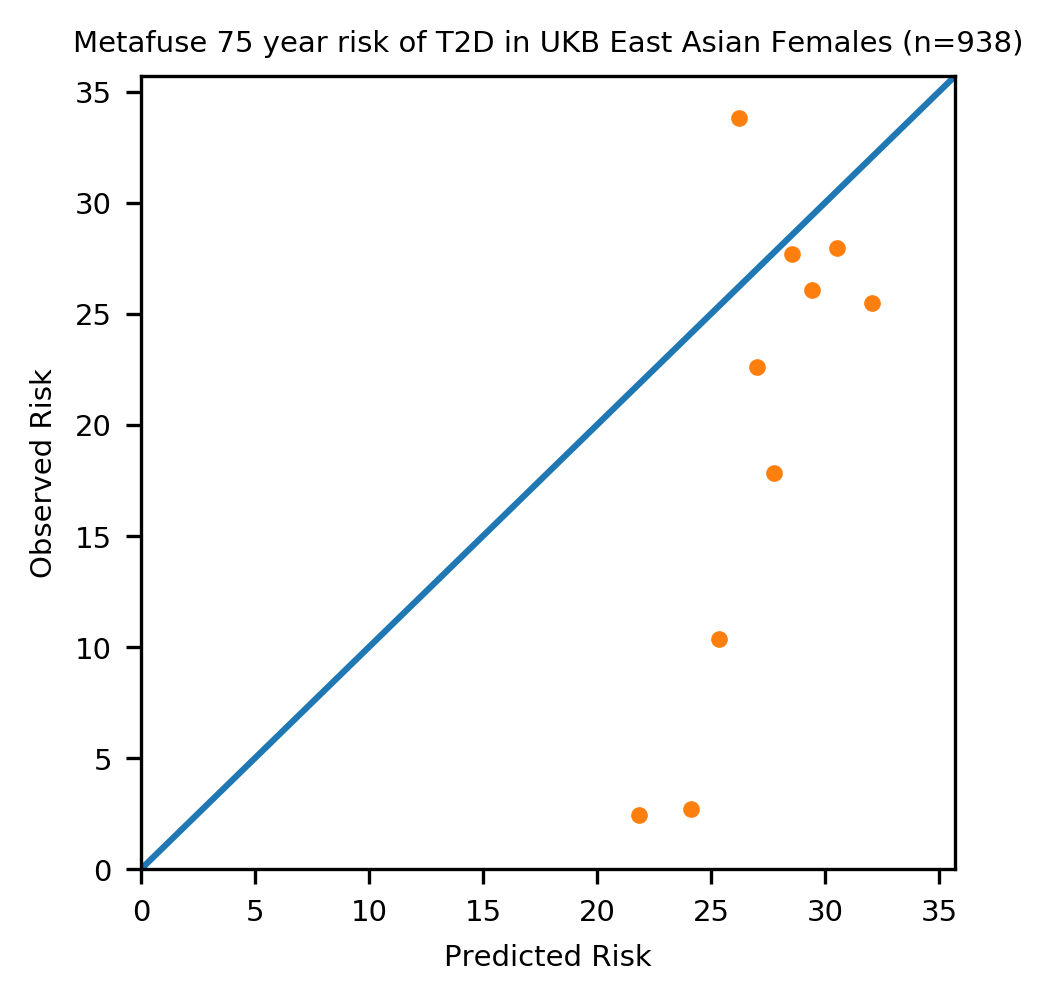

In [332]:
metafuse_eas_risk_male_fd = metafuse_eas_risk_male.join(eas_data_metafuse_male)

plot_calibration_km_rcox123(metafuse_eas_risk_male_fd.mfuse_risk, metafuse_eas_risk_male_fd, baseline_age_male_eas, "Metafuse 75 year risk of T2D in UKB East Asian Males (n=565)", cens=3286.0, bins=10, col="age_disease", truncation=False)


metafuse_eas_risk_female_fd = metafuse_eas_risk_female.join(eas_data_metafuse_female)

plot_calibration_km_rcox123(metafuse_eas_risk_female_fd.mfuse_risk, metafuse_eas_risk_female_fd, baseline_age_female_eas, "Metafuse 75 year risk of T2D in UKB East Asian Females (n=938)", cens=3286.0, bins=10, col="age_disease", truncation=False)


# Weighted Average of Beta

In [333]:
def apply_metafuse_weighted1(df,df_beta,baseline):
    
    #Average Risk
    average_risk = (df_beta.mean()).sum()
    
    #Features Multiplied with Mfuse params
    feature_x_params = df * df_beta
    #print(feature_x_params)

    #Sum the features
    feature_x_params['sum_features'] = feature_x_params[list(feature_x_params.columns)].sum(axis=1)
    
    #Calculating PCE risk with survival hazard formula
    metafuse_risk = pd.DataFrame(1 - pow(baseline, np.exp(feature_x_params['sum_features'] - average_risk)))
    metafuse_risk = metafuse_risk.rename(columns={"sum_features":"mfuse_risk"})
    return metafuse_risk

In [335]:
def weighted_average(admixed_pop_wa, eur_metafuse_beta, sas_metafuse_beta, afr_metafuse_beta, eas_metafuse_beta):
    
    beta_dict ={'EUR':eur_metafuse_beta , "SAS":sas_metafuse_beta, 'AFR':afr_metafuse_beta, "EAS":eas_metafuse_beta, "AMR":sas_metafuse_beta}
    
    cols = ['pca1_x','pca2_x','pca3_x','pca4_x','geno_array_x','prs']
    
    beta_cols = ['pca1_x_beta','pca2_x_beta','pca3_x_beta','pca4_x_beta','geno_array_x_beta','prs_beta']
    
    admixed_pop_wa.loc[:,beta_cols] = 0
    for anc in beta_dict:
        for i,col in enumerate(cols):
            temp = beta_dict[anc][col] * admixed_pop_wa[anc].astype(float)
            #print(temp)
            #print(admixed_pop_wa.loc[:,beta_cols[i]])
            admixed_pop_wa.loc[:,beta_cols[i]] = admixed_pop_wa.loc[:,beta_cols[i]]+temp
            #print(admixed_pop_wa.loc[:,beta_cols[i]])
    
    return admixed_pop_wa


def get_wa_beta(df):
    
    admixed_pop_beta = df[['pca1_x_beta','pca2_x_beta','pca3_x_beta','pca4_x_beta','geno_array_x_beta','prs_beta']].copy()

    admixed_pop_beta = admixed_pop_beta.rename(columns={"pca1_x_beta": "pca1_x", "pca2_x_beta": "pca2_x", "pca3_x_beta":"pca3_x", "pca4_x_beta":"pca4_x", "geno_array_x_beta":"geno_array_x", "prs_beta":"prs"}).copy()
    
    return admixed_pop_beta


In [336]:
#Weighted Average for admixed population

admixed_data_male_wa = weighted_average(admixed_data_male.copy(), eur_metafuse_beta_male, sas_metafuse_beta_male, afr_metafuse_beta_male, eas_metafuse_beta_male)
admixed_data_female_wa = weighted_average(admixed_data_female.copy(), eur_metafuse_beta_female, sas_metafuse_beta_female, afr_metafuse_beta_female, eas_metafuse_beta_female)


In [337]:
#Get the Beta
admixed_data_male_wa_beta = get_wa_beta(admixed_data_male_wa)
admixed_data_female_wa_beta = get_wa_beta(admixed_data_female_wa)

In [339]:
baseline_male_admixed = 0.631
baseline_female_admixed = 0.695

In [340]:
metafuse_admixed_risk_male = apply_metafuse_weighted1(admixed_data_male_wa, admixed_data_male_wa_beta, baseline_male_admixed)
metafuse_admixed_risk_female = apply_metafuse_weighted1(admixed_data_female_wa, admixed_data_female_wa_beta, baseline_female_admixed)

In [344]:
metafuse_admixed_risk_male.shape

(370, 1)

([0.0,
  40.000000000000014,
  53.84615384615385,
  51.7241379310345,
  47.76785714285714,
  61.022556390977435,
  37.91806020066887,
  18.74999999999999,
  14.28571428571428,
  20.383222091001997,
  37.777777777777786],
 [12.037187030544555,
  15.158761990510982,
  16.811870487076057,
  18.29486980089992,
  19.61702774050212,
  21.367032326116366,
  23.23776487481138,
  25.565316595073746,
  28.655818658917077,
  33.40431909721136,
  44.765657210268316])

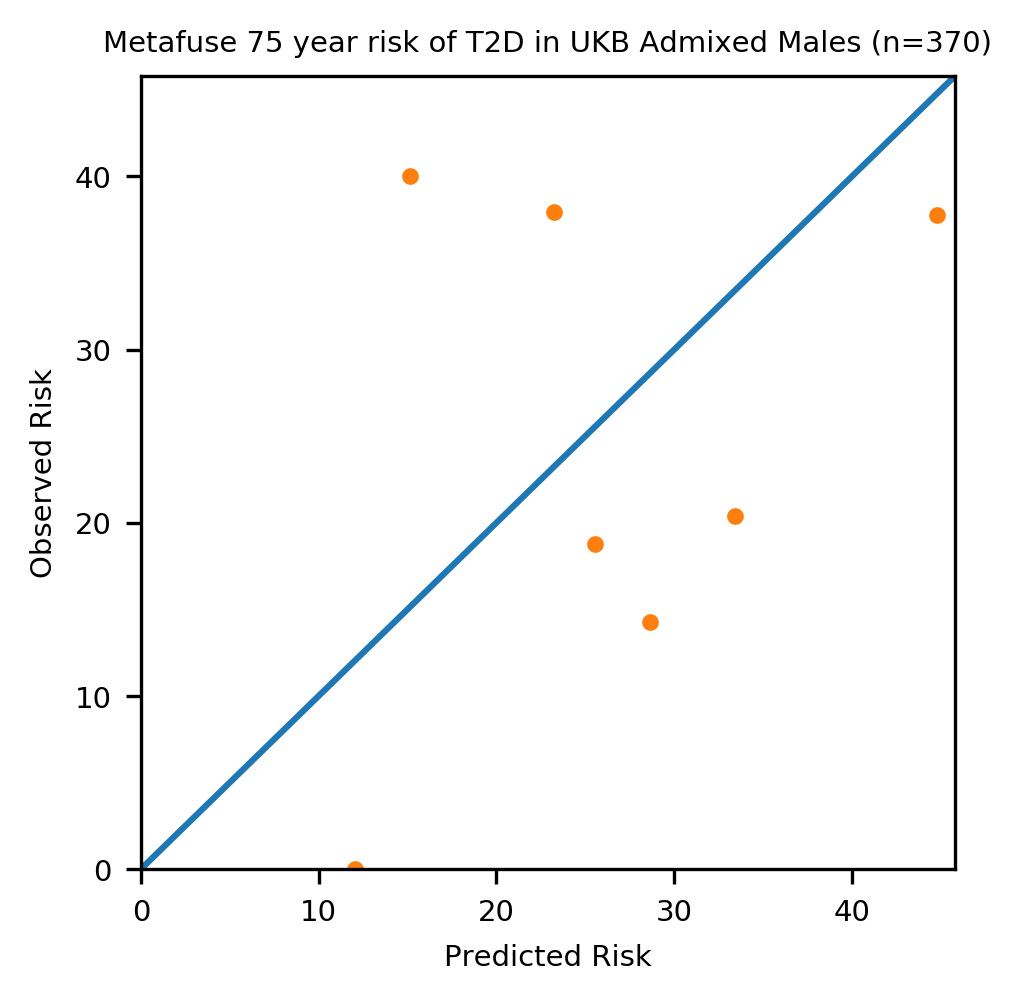

In [345]:
metafuse_admixed_risk_male_fd = metafuse_admixed_risk_male.join(admixed_data_male_wa)

plot_calibration_km_rcox123(metafuse_admixed_risk_male_fd.mfuse_risk, metafuse_admixed_risk_male_fd, 75, "Metafuse 75 year risk of T2D in UKB Admixed Males (n=370)", cens=3286.0, bins=10, col="age_disease", truncation=False)

In [348]:
admixed_data_female_wa.shape

(626, 24)

([0.0,
  9.090909090909083,
  0.0,
  8.783783783783772,
  42.96038198477221,
  42.23938223938224,
  37.38888888888891,
  7.0070992651637525,
  44.281388306545566,
  62.49070977331846,
  33.33333333333335],
 [14.22312637273772,
  18.413397607598753,
  19.64275404223093,
  20.36996627247569,
  21.098535473044763,
  21.83127715442321,
  22.674016138285257,
  24.49270099352767,
  27.795545569226416,
  33.05878006497363,
  47.424716781027854])

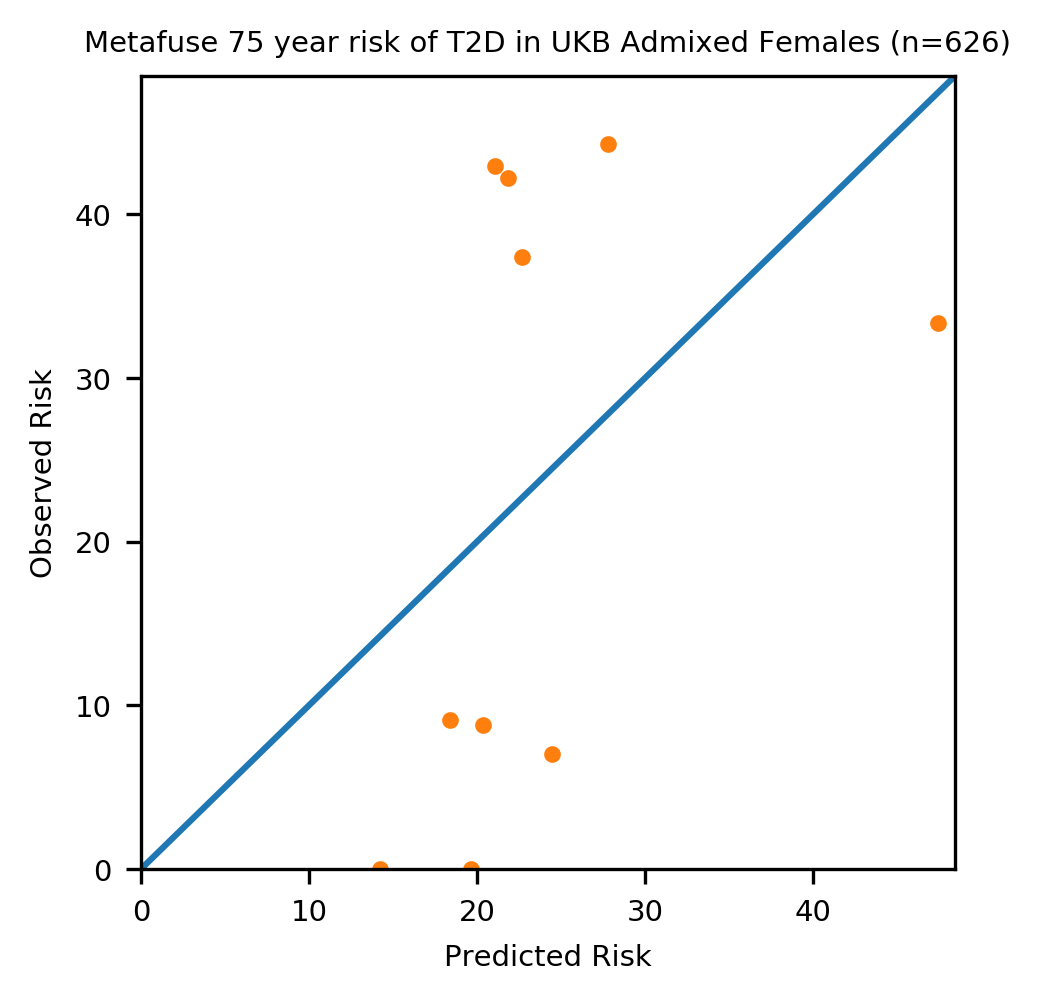

In [350]:
metafuse_admixed_risk_female_fd = metafuse_admixed_risk_female.join(admixed_data_female_wa)

plot_calibration_km_rcox123(metafuse_admixed_risk_female_fd.mfuse_risk, metafuse_admixed_risk_female_fd, 75, "Metafuse 75 year risk of T2D in UKB Admixed Females (n=626)", cens=3286.0, bins=10, col="age_disease", truncation=False)

# PARSE

In [ ]:
beta_eur = {e:eur_metafuse_beta[e].values[0] for e in eur_metafuse_beta if e != 'Unnamed: 0'}

pd.Series(beta_eur)

In [ ]:
beta = {}
for e in eur_metafuse_beta:
    if e!='Unnamed: 0':
        beta[e] = eur_metafuse_beta[e].values[0]

beta

In [ ]:
survival_probability_calibration(admixed_model_full, reduced[col].dropna(), t0=75)

In [ ]:
afr_compare_risk_gender = afr_compare_risk.join(afr_data.gender)
afr_compare_risk_gender_male = afr_compare_risk_gender[afr_compare_risk_gender['gender']==1]
afr_compare_risk_gender_female = afr_compare_risk_gender[afr_compare_risk_gender['gender']==0]
afr_compare_risk_gender.gender.value_counts()


admixed_compare_risk.affected.value_counts()
admixed_compare_risk.shape


sas_compare_risk.affected.value_counts(0)


plot_altair(admixed_compare_risk, "Admixed Age Disease")

# Cox Model from R Script

In [ ]:
plot_calibration_generic(pd.DataFrame(female_final_data.Cox_risk), female_final_data.dropna() , risk='Cox_risk', lim=0.25)

eur_mfuse_male = eur_mfuse[eur_mfuse['gender']==1]
eur_mfuse_female = eur_mfuse[eur_mfuse['gender']==0]

eur_data_male = eur_mfuse_male.join(eur_data.drop(columns=['affected','gender']))
eur_data_female = eur_mfuse_female.join(eur_data.drop(columns=['affected','gender']))

plot_calibration_generic(pd.DataFrame(eur_data_male.mfuse_risk), eur_data_male , risk='mfuse_risk',lim = 0.1)
plot_calibration_generic(pd.DataFrame(eur_data_female.mfuse_risk), eur_data_female , risk='mfuse_risk',lim = 0.2)

Weighted Average

In [ ]:
#Script to generate weighted average for beta

beta_dict ={'EUR':eur_metafuse_beta , "SAS":sas_metafuse_beta, 'AFR':afr_metafuse_beta, "EAS":eas_metafuse_beta, "AMR":sas_metafuse_beta}

cols = ['pca1_x','pca2_x','pca3_x','pca4_x','geno_array_x','prs','gender']

beta_cols = ['pca1_x_beta','pca2_x_beta','pca3_x_beta','pca4_x_beta','geno_array_x_beta','prs_beta','gender_beta']

admixed_pop_wa.loc[:,beta_cols] = 0
for anc in beta_dict:
    for i,col in enumerate(cols):
        temp = beta_dict[anc][col] * admixed_pop_wa[anc].astype(float)
        #print(temp)
        #print(admixed_pop_wa.loc[:,beta_cols[i]])
        admixed_pop_wa.loc[:,beta_cols[i]] = admixed_pop_wa.loc[:,beta_cols[i]]+temp
        #print(admixed_pop_wa.loc[:,beta_cols[i]])
      
        
'''   
    admixed_pop_wa['pca1_x_beta'] = beta_dict[anc]['pca1_x'] * admixed_pop_wa[anc].astype(float)
    admixed_pop_wa['pca2_x_beta'] = eur_metafuse_beta['pca2_x'] * admixed_pop_wa[anc].astype(float)
    admixed_pop_wa['pca3_x_beta'] = eur_metafuse_beta['pca3_x'] * admixed_pop_wa[anc].astype(float)
    admixed_pop_wa['pca4_x_beta'] = eur_metafuse_beta['pca4_x'] * admixed_pop_wa[anc].astype(float)
    admixed_pop_wa['geno_array_x_beta'] = eur_metafuse_beta['geno_array_x'] * admixed_pop_wa[anc].astype(float)
    admixed_pop_wa['prs_beta'] = eur_metafuse_beta['prs'] * admixed_pop_wa[anc].astype(float)
    admixed_pop_wa['gender_beta'] = eur_metafuse_beta['gender'] * admixed_pop_wa[anc].astype(float)
    
''' 

admixed_pop_wa.head()

In [ ]:
admixed_pop_df = admixed_pop_wa[['pca1_x','pca2_x','pca3_x','pca4_x','geno_array_x','prs','gender']].copy()

admixed_pop_beta = admixed_pop_wa[['pca1_x_beta','pca2_x_beta','pca3_x_beta','pca4_x_beta','geno_array_x_beta','prs_beta','gender_beta']].copy()

admixed_pop_beta = admixed_pop_beta.rename(columns={"pca1_x_beta": "pca1_x", "pca2_x_beta": "pca2_x", "pca3_x_beta":"pca3_x", "pca4_x_beta":"pca4_x", "geno_array_x_beta":"geno_array_x", "prs_beta":"prs", "gender_beta":"gender"}).copy()



metafuse_admixed_risk_wa =apply_metafuse_weighted(admixed_pop_df.copy(), admixed_pop_beta.copy(),0.3444998)
#admixed_compare_risk_wa = compare_risk_data(metafuse_admixed_risk_wa, admixedpreds, admixed75, admixed_pop)

metafuse_admixed_risk_wa
plot_altair(admixed_compare_risk_wa, "Admixed Weghted Average")
admixed_compare_risk_wa.to_csv("admixed_compare_risk_wa.csv")

In [ ]:
def plot_calibration_generic(predictions,original_dataset, risk='cox_risk', title="Cox", lim=0):
    """
    Only suitable for 75 risk
    """
    #predictions = predictions.join(original_dataset)
    predictions = original_dataset
    predictions.loc[:,'binned'] = np.round(stats.rankdata(predictions[risk],'average')/predictions.shape[0]*6, 0)
    
    
    x = []
    y= []
    for i in np.sort(predictions['binned'].unique()):
        individual_in_bin = predictions[predictions['binned'] == i]
        average_actual = individual_in_bin['affected'].mean()
        average_predicted = individual_in_bin[risk].mean()
        x.append(average_predicted)
        y.append(average_actual)
        
    
    plt.figure(figsize=(2, 2), dpi=300)
    plt.plot([i for i in range(0,90)],[i for i in range(0,90)])
    plt.plot(x,y,'.')
    plt.xlim(0,lim)
    plt.ylim(0,lim)
    plt.xlabel('Predicted Risk')
    plt.ylabel('Observed Risk')
    plt.title(title)
          
 
    return x,y 
